# **CSCI323 | Modern AI**
## **Group Assignment**
---
<div style="text-align: left;">

### **Group No: 18**

### **Group Member Information:**
| Name | Student ID |
|:--- |:--- |
| Loh Chin Yee | 7687278 |
| Chua Cheng Yi | 7897509 |
| Yeonjae Lim | 7914180 |
| Jiwon Moon | 7923569 |
| Swam Pyae Aung | 7687436 |
| Oh Hwee Xin | 6663175 |

</div>

# **Data Load & Overall Exploration**
### Dataset: TREC07

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('email_origin.csv')
print(f'The shape {df.shape}')
print(f'The columns {df.columns}')

The shape (75419, 2)
The columns Index(['label', 'origin'], dtype='object')


In [ ]:
spam_emails = df[df['label'] == 1]
ham_emails = df[df['label'] == 0]

print(f'The size of spam emails is {spam_emails.shape}')
print(f'The size of ham emails is {ham_emails.shape}')

The size of spam emails is (50199, 2)
The size of ham emails is (25220, 2)


### Check for empty data

In [ ]:
none_row = df.isna().sum()
print(f'The number of none rows is \n{none_row}')

print(f"The number of row with empty string is {df[df['origin'] == ''].shape[0]}")

The number of none rows is 
label     0
origin    0
dtype: int64
The number of row with empty string is 0


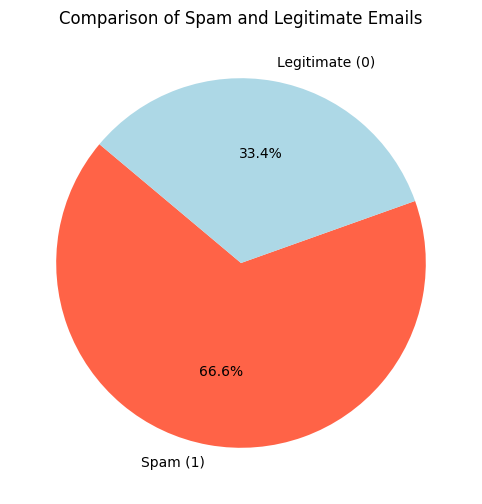

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of spam and legitimate emails
email_counts = df['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(email_counts, labels=['Spam (1)', 'Legitimate (0)'], autopct='%1.1f%%', startangle=140, colors=['tomato', 'lightblue'])
plt.title('Comparison of Spam and Legitimate Emails')
plt.show()

## Content type pure image
Right now, we ignore all the pure image row.
Row 7 is the is the pure image spam email.

---

# **Process the email from `df['origin']`**
### **1. Feature Extraction: Extract various Header Tags**
- Extract key email headers (Return-Path, From, Received, To, Subject, X-Spam-Status, Authentication, etc.)
- Extract List-related headers (List-Unsubscribe, List-Subscribe, List-Post, List-Help)
- Collect all header information

### **2. Data Cleaning**
- Extract plain text from HTML/XML content (using BeautifulSoup)
- Handle encoding issues (attempt UTF-8 decoding)
- Decode Base64 encoded content

### **3. Feature Engineering: mailto_anchor, mailto_header**
- Extract 'mailto:' links from email body
- Extract 'mailto:' links from headers

### **4. Data Transformation**
- Convert extracted and cleaned information into a structured format
  * Organize each email's features into a Python dictionary
  * Transform unstructured data (raw emails) into structured data (organized dictionaries)
- Structure the entire dataset
  * Accumulate processed email data into a list of dictionaries
  * Arrange data in a format easily convertible to a pandas DataFrame

### **Extract headers and body**

In [ ]:
from email.errors import HeaderParseError
import base64
import re
import email
from email import policy
from bs4 import BeautifulSoup

def process_email(rawemail):
    try:
        msg = email.message_from_string(rawemail, policy=policy.default)
    except Exception as e:
        print(f'Error in parsing: {e}')
        return None

    def get_header(header_name):
        if header_name == 'Received':
            try:
                return msg.get_all(header_name, failobj=[])
            except KeyError:
                return None
            except email.errors.HeaderParseError:
                return None

        try:
            return msg[header_name]
        except KeyError:
            return None
        except email.errors.HeaderParseError:
            return None

    headers = {
        'return_path': get_header('Return-Path'),
        'from': get_header('From'),
        'received': get_header('Received'),
        'subject': get_header('Subject'),
        'list_unsubscribe': get_header('List-Unsubscribe'),
        'list_subscribe': get_header('List-Subscribe'),
        'list_post': get_header('List-Post'),
        'list_help': get_header('List-Help')
    }

    def extract_x_spam_status_values(origin_text):
        match = re.search(r'X-Spam-Status: (\w+)', origin_text)
        if match:
            return match.group(1).lower()
        return 'no_info'

    # If the email is multipart
    def get_body(msg):
        body_parts = []

        def decode_payload(part_):
            payload_ = part_.get_payload(decode=True)
            if part_.get("Content-Transfer-Encoding") == "base64":
                payload_ = base64.b64decode(payload_)
            return payload_

        def is_txt_content(content):
            return all(ord(c) < 128 for c in content[:1000])

        if msg.is_multipart():
            for part in msg.walk():
                if part.get_content_type() in ["text/plain", "text/html", "text/xml"]:
                    try:
                        payload = decode_payload(part)
                        decoded = payload.decode('utf-8')
                        if is_txt_content(decoded):
                            body_parts.append((decoded, part.get_content_type()))
                    except (UnicodeDecodeError, base64.binascii.Error):
                        continue
        else:
            try:
                payload = decode_payload(msg)
                decoded = payload.decode('utf-8')
                if is_txt_content(decoded):
                    body_parts.append((decoded, msg.get_content_type()))
            except (UnicodeDecodeError, base64.binascii.Error):
                pass
        return body_parts

    body_parts = get_body(msg)

    def clean_html_xml(content, content_type):
        soup = None
        if content:
            try:
                if "text/html" in content_type:
                    soup = BeautifulSoup(content, "html.parser")
                elif "text/xml" in content_type:
                    soup = BeautifulSoup(content, "xml")
                else:
                    return content, None
                return soup.get_text(), soup
            except Exception as e:
                print(f'Error in parsing content: {e}')
                return content, None
        return "", None

    # Body cleaning
    soup = None
    cleaned_body = ""
    for body, content_type in body_parts:
        cleaned_txt, soup = clean_html_xml(body, content_type)
        cleaned_body += cleaned_txt

    def extract_mailto_links(soup):
        mailtos = []
        if soup:
            for link in soup.find_all("a"):
                if link.has_attr("href"):
                    if link["href"].startswith("mailto:"):
                        mailtos.append(link["href"])
        return mailtos

    mailtos_a = extract_mailto_links(soup)

    def get_all_headers(msg):
        headers_ = {}
        for key in msg.keys():
            try:
                headers_[key] = msg[key]
            except HeaderParseError:
                headers_[key] = "HeaderParseError"
            except Exception as e:
                headers_[key] = f"Error: {e}"
        return headers_

    all_headers = get_all_headers(msg)

    def extract_mailto_from_header(headers):
        mailtos = []
        mailto_pattern = re.compile(r'mailto:\S+')
        for header_name, header_value in headers.items():
            if header_value:
                found_links = mailto_pattern.findall(header_value)
                for link in found_links:
                    mailtos.append((header_name, link))
        return mailtos

    def check_authentication_headers(email_headers):
        spf = any(re.search(r'spf', header.lower()) for header in email_headers.keys())
        dkim = any(re.search(r'dkim', header.lower()) for header in email_headers.keys())
        dmarc = any(re.search(r'dmarc', header.lower()) for header in email_headers.keys())

        return {
            'SPF': spf,
            'DKIM': dkim,
            'DMARC': dmarc
        }

    header_authentication = check_authentication_headers(all_headers)
    header_mailtos = extract_mailto_from_header(all_headers)

    return {
        'return_path': headers['return_path'],
        'from': headers['from'],
        'received': headers['received'],
        'subject': headers['subject'],
        'body': cleaned_body,
        'list_unsubscribe': headers['list_unsubscribe'],
        'x_spam_status': extract_x_spam_status_values(rawemail),
        'authentication': header_authentication,
        'list_subscribe': headers['list_subscribe'],
        'list_post': headers['list_post'],
        'list_help': headers['list_help'],
        'anchor_mailtos': mailtos_a,
        'header_mailtos': header_mailtos,
    }

In [ ]:
data = {
    'label': [],
    'return_path': [],
    'from': [],
    'received': [],
    'list_unsubscribe': [],
    'x_spam_status': [],
    'authentication': [],
    'list_subscribe': [],
    'list_post': [],
    'list_help': [],
    'subject': [],
    'mailto_anchor': [],
    'mailto_header': [],
    'body': []
}

for index, row in df.iterrows():
    features = process_email(row['origin'])
    if features:
        data['label'].append(row['label'])
        data['return_path'].append(features['return_path'])
        data['from'].append(features['from'])
        data['received'].append(features['received'])
        data['subject'].append(features['subject'])
        data['body'].append(features['body'])  # Cleaned body
        data['x_spam_status'].append(features['x_spam_status'])
        data['authentication'].append(features['authentication'])
        data['list_unsubscribe'].append(features['list_unsubscribe'])
        data['list_subscribe'].append(features['list_subscribe'])
        data['list_post'].append(features['list_post'])
        data['list_help'].append(features['list_help'])
        data['mailto_anchor'].append(features['anchor_mailtos'])
        data['mailto_header'].append(features['header_mailtos'])

# Convert the dictionary into a DataFrame
email_df = pd.DataFrame(data)

C:\Users\X390\AppData\Local\Temp\ipykernel_5848\2293856399.py:84: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(content, "html.parser")


## **Save Dataframe as a new csv file**

email_df.to_csv('processed_output_v3.csv', index=False, escapechar='\\')

In [ ]:
import pandas as pd
import numpy as np
import ast

def convert_to_none(value):
    return None if pd.isna(value) or value == '' else str(value)

email_df = pd.read_csv('final_output.csv', converters={
    'label': int,
    'return_path': str,
    'from': str,
    'received': str,
    'list_unsubscribe': convert_to_none,
    'authentication': ast.literal_eval,
    'list_subscribe': convert_to_none,
    'list_post': convert_to_none,
    'list_help': convert_to_none,
    'subject': str,
    'mailto_anchor': ast.literal_eval,
    # 'mailto_header': lambda x : [tuple(item.split(',')) for item in ast.literal_eval(x)],
    'mailto_header': ast.literal_eval,
})

## **Text Preprocessing** : body

In [ ]:
# first preprocess
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_body(body):
  body = re.sub(r'http\S+', '', body)
  msg = re.sub(r'[^a-zA-Z0-9\s]', '', body)
  msg = msg.lower()
  msg = msg.translate(str.maketrans('', '', string.punctuation))
  words = word_tokenize(msg)
  words = [word for word in words if word not in stop_words]
  return ' '.join(words)
#   return msg

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\X390\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\X390\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Fill missing values:** body, subject

In [ ]:
empty_body_num = email_df['body'].isnull().sum()
print(f'The number of empty bodies is {empty_body_num}')

The number of empty bodies is 14545


In [ ]:
email_df['body'] = email_df['body'].fillna('')
email_df['body'] = email_df['body'].apply(preprocess_body)

In [ ]:
print(f'The number of empty subject is {email_df["subject"].isnull().sum()}')

The number of empty subject is 793


In [ ]:
email_df['subject'] = email_df['subject'].fillna('')
email_df['subject'] = email_df['subject'].apply(preprocess_body)

## **Exploration:**
### Observe the charateristics of ham email **subjects** and **bodies**

In [ ]:
# print the first 10 subjects
legitimate_emails_df = email_df[email_df['label'] == 0]
for i in range(10):
    print(f'Subejct {i}')
    print(legitimate_emails_df.iloc[i, 7])
    print(f'Body {i}')
    print(legitimate_emails_df.iloc[i, 10])
    print('*'*50)

Subejct 0
typo debianreadme
Body 0
hi ive updated gulus check mirrors seems little typo debianreadme file example ftpftpfrdebianorgdebianreadme testing lenny access release diststesting current tested development snapshot named etch packages tested unstable passed automated tests propogate release etch replace lenny like readmehtml yan morin consultant en logiciel libre yanmorinsavoirfairelinuxcom 5149941556 unsubscribe email debianmirrorsrequestlistsdebianorg subject unsubscribe trouble contact listmasterlistsdebianorg
**************************************************
Subejct 1
r confidenceintervals help
Body 1
hi use r find 90 confidenceinterval sensitivity specificity following diagnostic test particular diagnostic test multiple sclerosis conducted 20 ms patients 20 healthy subjects 6 ms patients classified healthy 8 healthy subjects classified suffering ms furthermore need find number ms patients required sensitivity 1 simple rcommand completely new r help please jochen view messa

In [ ]:
from collections import Counter

# Separate the spam and legitimate emails
spam_emails_body = email_df[email_df['label'] == 1]['body']
legit_emails_body = email_df[email_df['label'] == 0]['body']

# Count word frequencies for spam
spam_words = Counter()
spam_emails_body.apply(lambda x: spam_words.update(x.split()))

# Count word frequencies for legitimate emails
legit_words = Counter()
legit_emails_body.apply(lambda x: legit_words.update(x.split()))

# Get the most common words in spam and legitimate emails
spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

## **Analysis using Visualization**
### [1] Words from Body based on Spam Status - Barchart

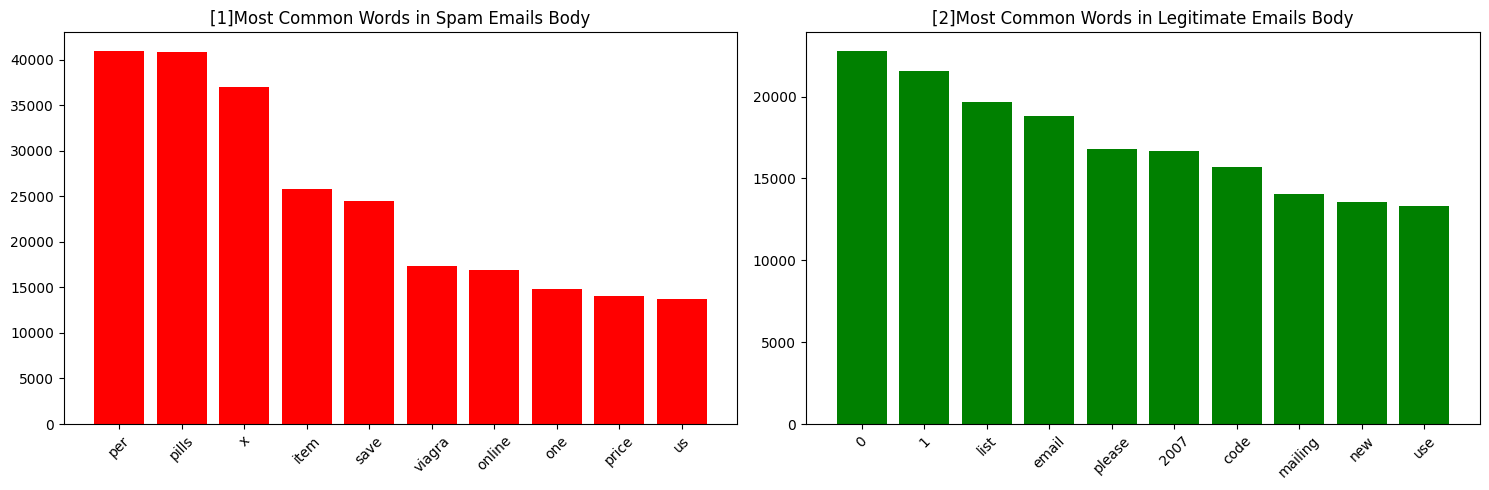

In [ ]:
import matplotlib.pyplot as plt

# Plotting the most common words in spam emails
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
plt.title('[1]Most Common Words in Spam Emails Body')
plt.xticks(rotation=45)

# Plotting the most common words in legitimate emails
plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
plt.title('[2]Most Common Words in Legitimate Emails Body')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Both graphs show the top 10 most frequently found words in the body, along with their frequencies, based on spam status.**

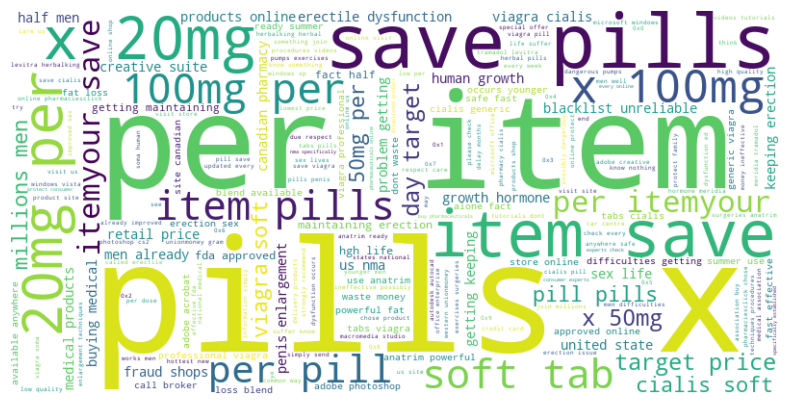

In [ ]:
from wordcloud import WordCloud


spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails_body))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Word cloud of the words captured in the body of spam emails: provides the same insights as the [1]bar graph**

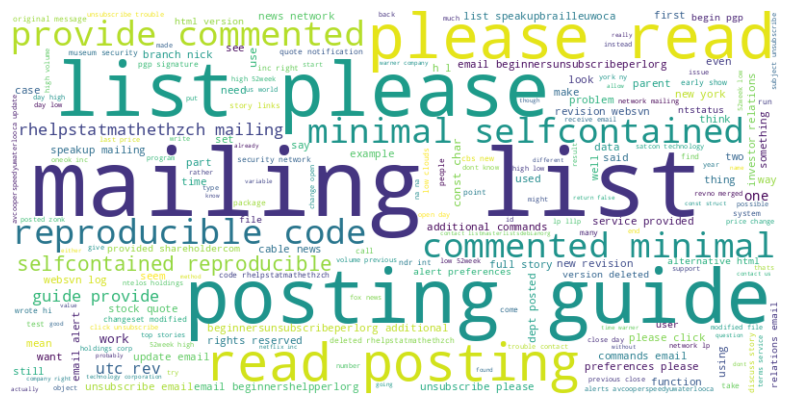

In [ ]:
legit_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(legit_emails_body))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(legit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Word cloud of the words captured in the body of legit emails: provides the same insights as the [1]bar graph**

# Common word analysis in Email subjects

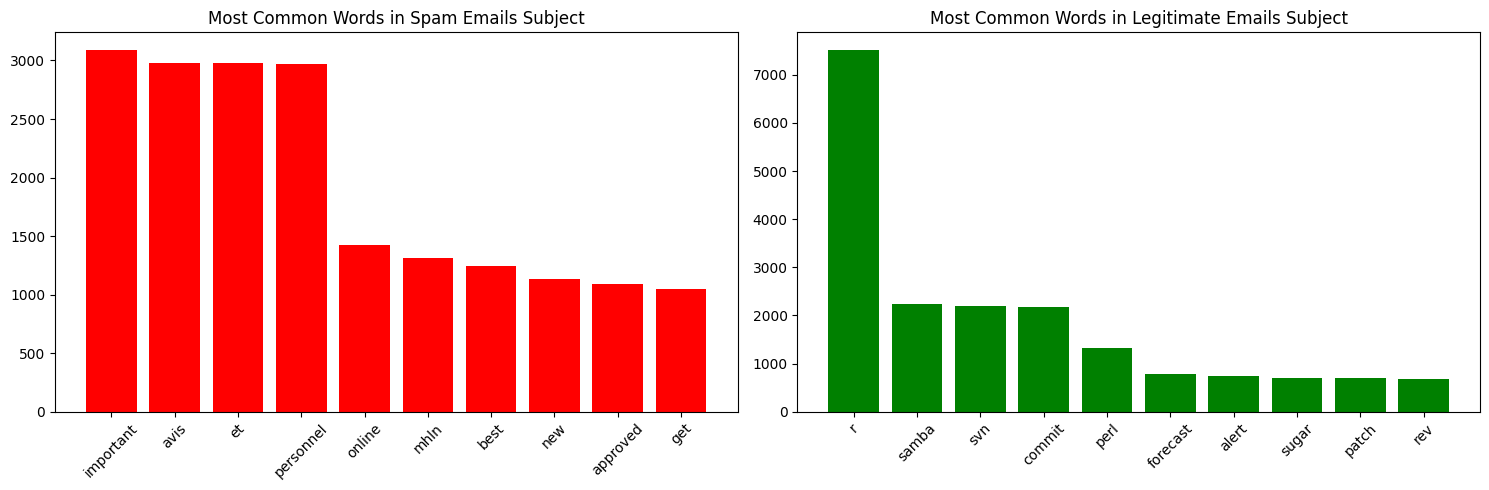

In [ ]:
spam_emails_subject = email_df[email_df['label'] == 1]['subject']
legit_emails_subject = email_df[email_df['label'] == 0]['subject']

# Count word frequencies for spam
spam_words = Counter()
spam_emails_subject.apply(lambda x: spam_words.update(x.split()))

legit_words = Counter()
legit_emails_subject.apply(lambda x: legit_words.update(x.split()))

spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
plt.title('Most Common Words in Spam Emails Subject')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
plt.title('Most Common Words in Legitimate Emails Subject')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

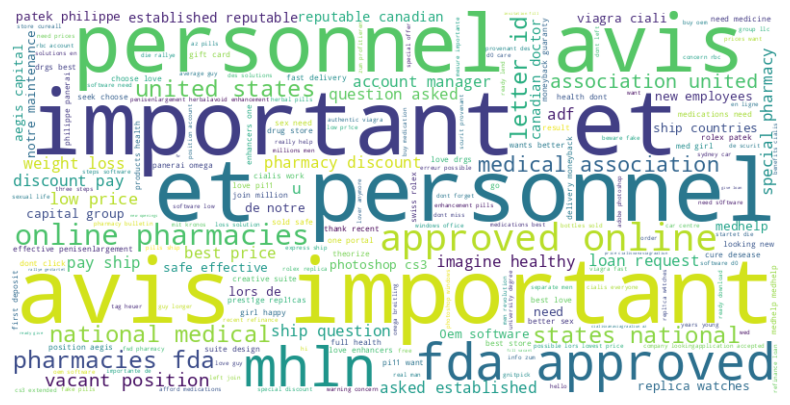

In [ ]:
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails_subject))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

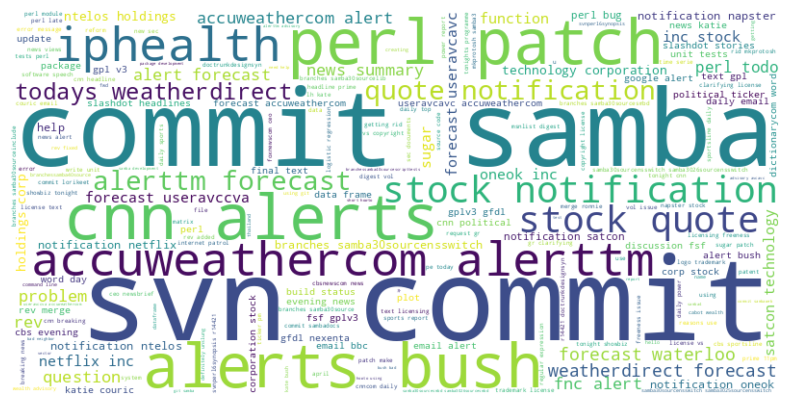

In [ ]:
legit_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(legit_emails_subject))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(legit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Bigram analysis on email body

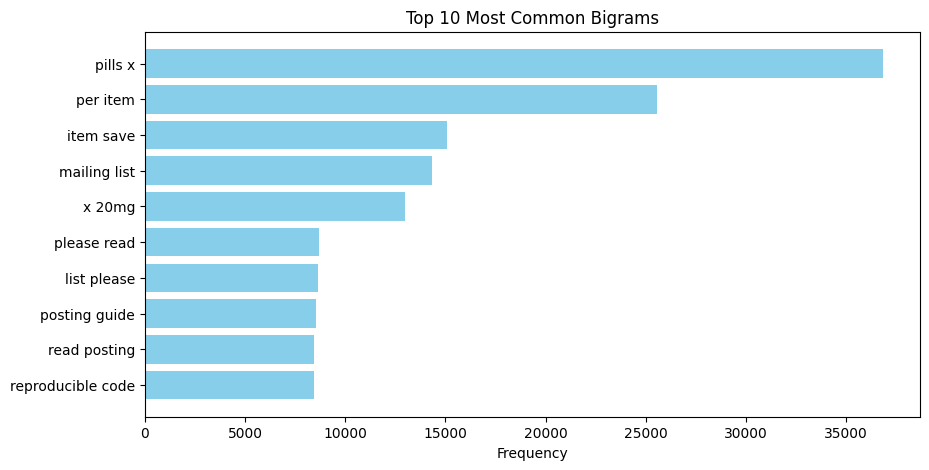

In [ ]:
from nltk import ngrams
import matplotlib.pyplot as plt
from collections import Counter

# Extract n-grams from text
def generate_ngrams(text, n=2):
    # Split the text into words
    words = text.split()
    # Ensure that there is no enough words
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

# Convert bigrams
email_df['bigrams'] = email_df['body'].apply(lambda x: generate_ngrams(x, n=2))

# count the frequencies
bigram_counts = Counter([bigram for sublist in email_df['bigrams'] for bigram in sublist])

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

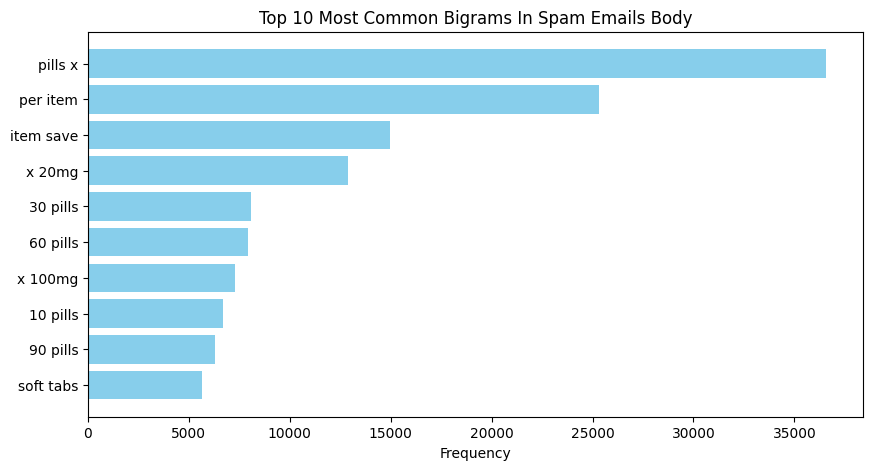

In [ ]:
spam_email_df = email_df[email_df['label'] == 1]

bigram_counts = Counter([bigram for sublist in spam_email_df['bigrams'] for bigram in sublist])

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams In Spam Emails Body')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

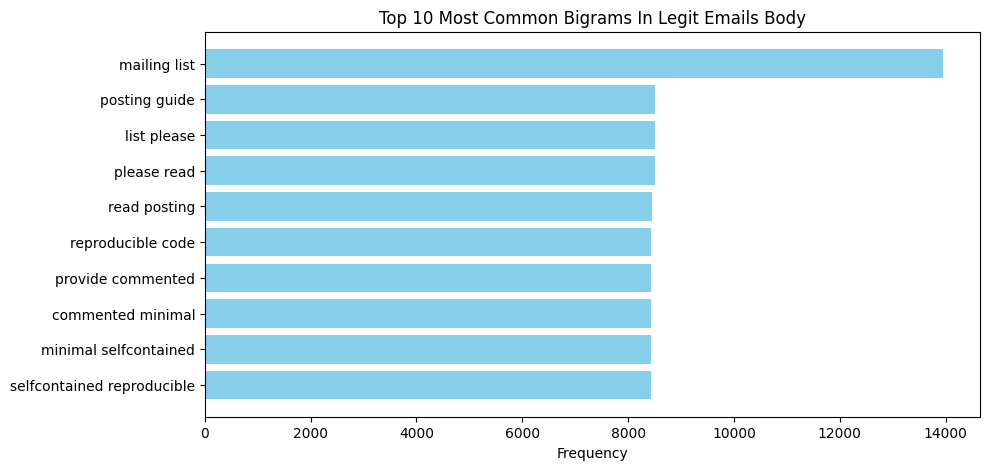

In [ ]:
legit_email_df = email_df[email_df['label'] == 0]

bigram_counts = Counter([bigram for sublist in legit_email_df['bigrams'] for bigram in sublist])

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams In Legit Emails Body')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

## Return path vs From header analysis

domain_comparison  Domain mismatch  Exact domain match  \
label                                                    
0                            17250                4026   
1                             8947               40921   

domain_comparison  Missing domain information  Subdomain match  
label                                                           
0                                           0             3944  
1                                          32              299  


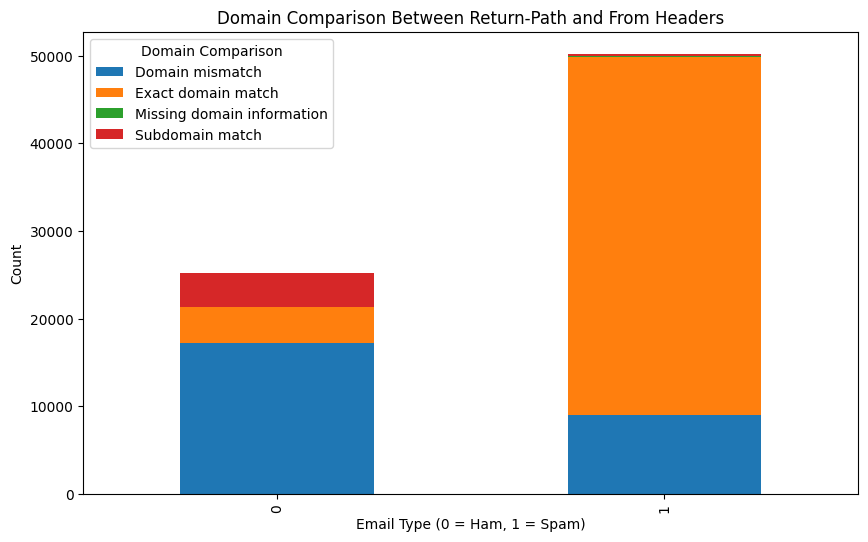

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def compare_returnpath_from(row):
    return_path = row['return_path']
    from_ = row['from']
    return_path_domain = re.search('@([\w.-]+)', return_path).group(1) if return_path and re.search('@([\w.-]+)', return_path) else None
    from_domain = re.search('@([\w.-]+)', from_).group(1) if from_ and re.search('@([\w.-]+)', from_) else None

    if return_path_domain and from_domain:
        if return_path_domain == from_domain:
            return "Exact domain match"
        elif return_path_domain.endswith(from_domain) or from_domain.endswith(return_path_domain):
            return "Subdomain match"
        else:
            return "Domain mismatch"
    else:
        return "Missing domain information"


email_df['domain_comparison'] = email_df.apply(compare_returnpath_from, axis=1)
email_df['domain_comparison'].head(10)

comparison_counts = email_df.groupby(['label', 'domain_comparison']).size().unstack(fill_value=0)
print(comparison_counts)

comparison_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Domain Comparison Between Return-Path and From Headers')
plt.xlabel('Email Type (0 = Ham, 1 = Spam)')
plt.ylabel('Count')
plt.legend(title='Domain Comparison')
plt.show()


In [ ]:
email_df.columns

Index(['label', 'return_path', 'from', 'received', 'to', 'list_unsubscribe',
       'list_subscribe', 'list_post', 'list_help', 'subject', 'mailto_anchor',
       'mailto_header', 'body', 'x_spam_status', 'authentication', 'bigrams',
       'domain_comparison'],
      dtype='object')

# Mailto analysis

Mailto normally sits in the headers.
Company need to place the mailto in the `List-Unsubscribe` to compliance the law. https://mailtrap.io/blog/list-unsubscribe-header/
So, if the email doesnt contain `List-Unsubscribe` when it is a *kinda marketing email*, then it is likely spam.

**However, take note not all the email doesnt contain List-Unsubscribe is spam email**.

From the random printing of mailto result shown that, as alot of the mailto in our dataset, there are two places for it, `List-` and `anchor` tag.

*Attacker might use custom header to bypass the spam email detection also*


### Textual analysis

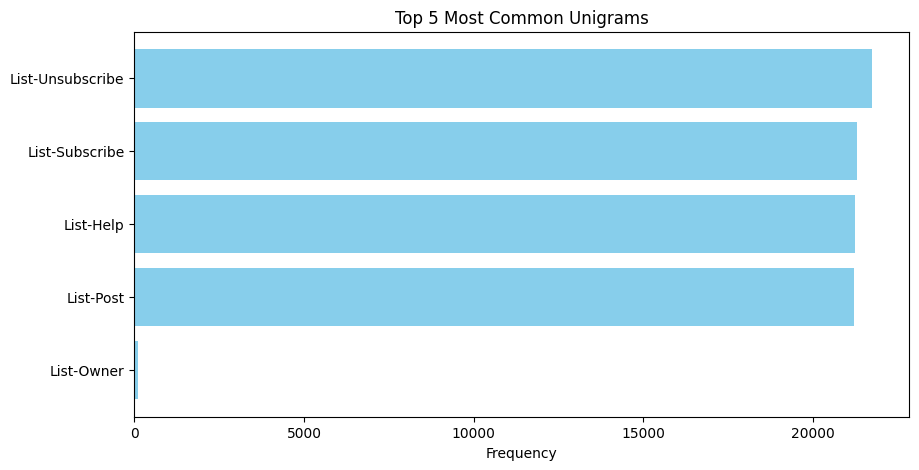

In [ ]:
import pandas as pd
import ast
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

def convert_to_tuple(value):
    try:
        parsed = ast.literal_eval(value)
        if not isinstance(parsed, (list, tuple)):
            return (parsed,)
        return tuple(parsed) if isinstance(parsed, list) else parsed
    except (ValueError, SyntaxError):
        return (value,)

email_df['mailto_header'] = email_df['mailto_header'].apply(convert_to_tuple)

def generate_ngrams(tuples_list, n=1):
    words = [t[0] for t in tuples_list if isinstance(t, tuple) and len(t) > 0]
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

# Convert to unigrams
email_df['unigram'] = email_df['mailto_header'].apply(lambda x: generate_ngrams(x, n=1))

# Count the frequencies of unigrams
unigram_counts = Counter([unigram for sublist in email_df['unigram'] for unigram in sublist])

# Get the most common unigrams
most_common_unigrams = unigram_counts.most_common(5)

# Convert to DataFrame for visualization
unigrams_df = pd.DataFrame(most_common_unigrams, columns=['Unigram', 'Frequency'])

# Plot the most common Unigrams
plt.figure(figsize=(10, 5))
plt.barh(unigrams_df['Unigram'], unigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 5 Most Common Unigrams')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

**List-Unsubscribe**: Allows recipients to easily opt out of future emails.

**List-Subscribe:** Enables users to easily subscribe or re-subscribe to the mailing list.

**List-Help:** Provides information on how to get assistance with the email list.

**List-Post**: Directs replies or posts to the entire mailing list, ensuring group communication and discussion among all members.

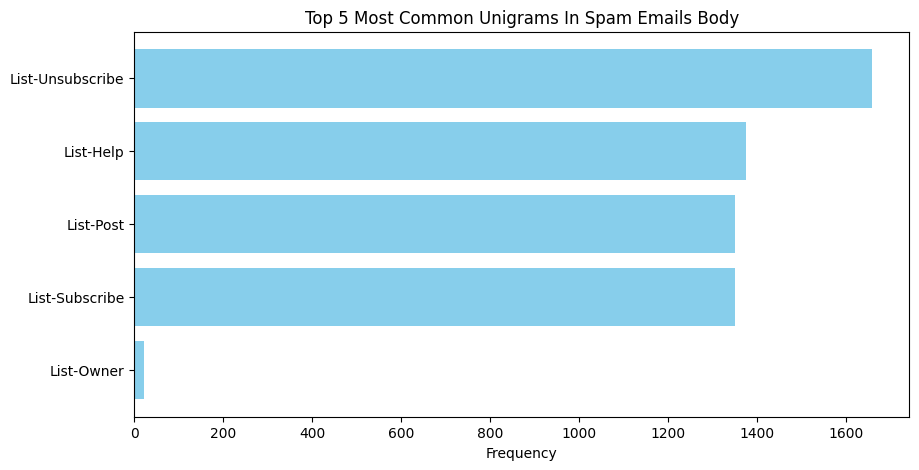

In [ ]:
# Filter the DataFrame to include only spam emails
spam_email_df = email_df[email_df['label'] == 1]

# Filter out rows where 'unigram' is an empty list or contains only empty strings
spam_email_df = spam_email_df[spam_email_df['unigram'].apply(lambda x: x != [] and all(i != '' for i in x))]

# Count the frequencies of unigrams
unigram_counts = Counter([unigram for sublist in spam_email_df['unigram'] for unigram in sublist])

# Get the most common Unigrams
most_common_unigrams = unigram_counts.most_common(5)

# Convert to DataFrame for visualization
unigrams_df = pd.DataFrame(most_common_unigrams, columns=['Unigram', 'Frequency'])

# Plot the most common Unigrams
plt.figure(figsize=(10, 5))
plt.barh(unigrams_df['Unigram'], unigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 5 Most Common Unigrams In Spam Emails Body')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

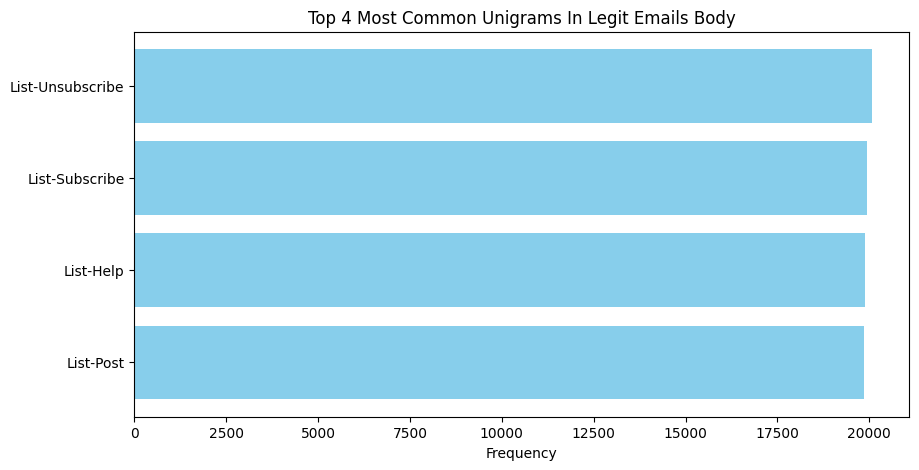

In [ ]:
# Filter the DataFrame to include only legit emails
spam_email_df = email_df[email_df['label'] == 0]

# Count the frequencies of unigrams
unigram_counts = Counter([unigram for sublist in spam_email_df['unigram'] for unigram in sublist])

# Get the most common Unigrams
most_common_unigrams = unigram_counts.most_common(4)

# Convert to DataFrame for visualization
unigrams_df = pd.DataFrame(most_common_unigrams, columns=['Unigram', 'Frequency'])

# Plot the most common Unigrams
plt.figure(figsize=(10, 5))
plt.barh(unigrams_df['Unigram'], unigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 4 Most Common Unigrams In Legit Emails Body')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

## Hypothesis 1: Spam emails will not include ['list-unsubscribe']

### Distribution analysis

In [ ]:
# Check if 'list_unsubscribe' is populated
email_df['list_unsubscribe_populated'] = email_df['list_unsubscribe'].apply(lambda x: 0 if pd.isna(x) or x == '[]' else 1)


In [ ]:
# Create a crosstab to compare list_unsubscribe_populated with the label
crosstab = pd.crosstab(email_df['list_unsubscribe_populated'], email_df['label'], normalize='index')

# Calculate percentages
not_spam_percentage = crosstab[0] * 100  # label 0 means not spam
spam_percentage = crosstab[1] * 100      # label 1 means spam

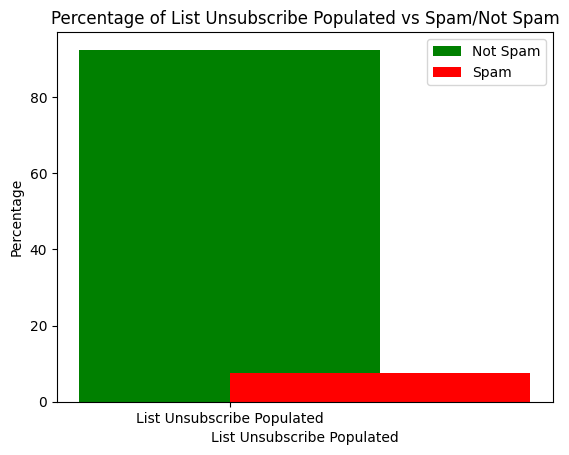

In [ ]:
# Create a bar chart
labels = ['List Unsubscribe Populated']
x = range(len(labels))

plt.bar(x, not_spam_percentage[1], width=0.4, label='Not Spam', color='green', align='center')
plt.bar(x, spam_percentage[1], width=0.4, label='Spam', color='red', align='edge')

plt.xlabel('List Unsubscribe Populated')
plt.ylabel('Percentage')
plt.title('Percentage of List Unsubscribe Populated vs Spam/Not Spam')
plt.xticks(ticks=x, labels=labels)
plt.legend()

plt.show()

To confirm whether if our hypothesis that the populated list_unsubscribe has a high correlation to non-spam, we compare with an unpopulated list_unsubscribe to see if there is a contrast in results. If there is a contrast, means that our hypothesis is correct.

In [ ]:
# Check if 'List Unsubscribe Populated' is populated or not
email_df['list_unsubscribe_populated'] = email_df['list_unsubscribe'].apply(lambda x: 0 if pd.isna(x) or x == '[]' else 1)

# Create a crosstab to compare list_unsubscribe_populated with the label
crosstab = pd.crosstab(email_df['list_unsubscribe_populated'], email_df['label'], normalize='index')

In [ ]:
# Calculate percentages for both scenarios
not_populated_not_spam_percentage = crosstab.loc[0, 0] * 100  # list_unsubscribe not populated, label 0 (not spam)
not_populated_spam_percentage = crosstab.loc[0, 1] * 100      # list_unsubscribe not populated, label 1 (spam)
populated_not_spam_percentage = crosstab.loc[1, 0] * 100      # list_unsubscribe populated, label 0 (not spam)
populated_spam_percentage = crosstab.loc[1, 1] * 100          # list_unsubscribe populated, label 1 (spam)

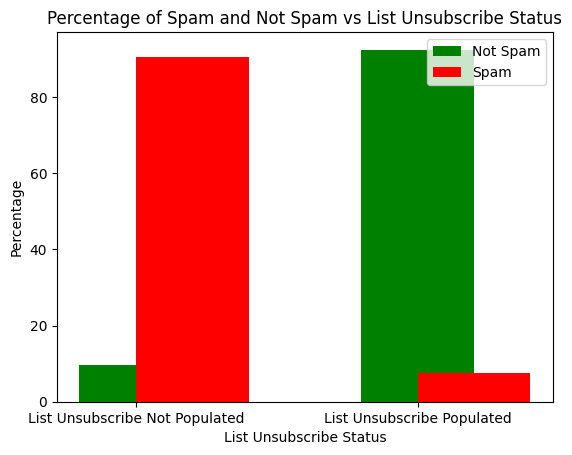

In [ ]:
# Create a bar chart
labels = ['List Unsubscribe Not Populated', 'List Unsubscribe Populated']
not_spam_percentages = [not_populated_not_spam_percentage, populated_not_spam_percentage]
spam_percentages = [not_populated_spam_percentage, populated_spam_percentage]

x = range(len(labels))

plt.bar(x, not_spam_percentages, width=0.4, label='Not Spam', color='green', align='center')
plt.bar(x, spam_percentages, width=0.4, label='Spam', color='red', align='edge')

plt.xlabel('List Unsubscribe Status')
plt.ylabel('Percentage')
plt.title('Percentage of Spam and Not Spam vs List Unsubscribe Status')
plt.xticks(ticks=x, labels=labels)
plt.legend()

plt.show()

This proves that if the list_unsubscribe column has something in it, it is likely not a spam, meaning the label column will be 0. Therefore, the hypothesis would be correct.

## Hypothesis 2: Spam emails will not include ['list-subscribe']

List-Subscribe: Enables users to easily subscribe or re-subscribe to the mailing list.

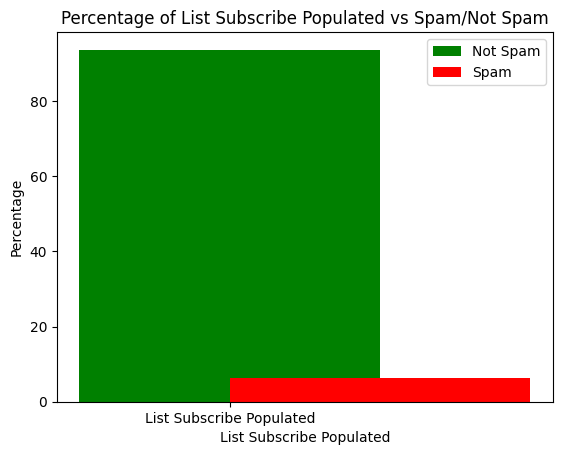

In [ ]:
import matplotlib.pyplot as plt

# Check if 'list_subscribe' is populated
email_df['list_subscribe_populated'] = email_df['list_subscribe'].apply(lambda x: 0 if pd.isna(x) or x == '[]' else 1)

# Create a crosstab to compare list_subscribe_populated with the label
crosstab = pd.crosstab(email_df['list_subscribe_populated'], email_df['label'], normalize='index')

# Calculate percentages
not_spam_percentage = crosstab[0] * 100  # label 0 means not spam
spam_percentage = crosstab[1] * 100      # label 1 means spam

# Create a bar chart
labels = ['List Subscribe Populated']
x = range(len(labels))

plt.bar(x, not_spam_percentage[1], width=0.4, label='Not Spam', color='green', align='center')
plt.bar(x, spam_percentage[1], width=0.4, label='Spam', color='red', align='edge')

plt.xlabel('List Subscribe Populated')
plt.ylabel('Percentage')
plt.title('Percentage of List Subscribe Populated vs Spam/Not Spam')
plt.xticks(ticks=x, labels=labels)
plt.legend()

plt.show()

To confirm whether if our hypothesis that the populated list_subscribe has a high correlation to non-spam, we compare with an unpopulated list_subscribe to see if there is a contrast in results. If there is a contrast, means that our hypothesis is correct.

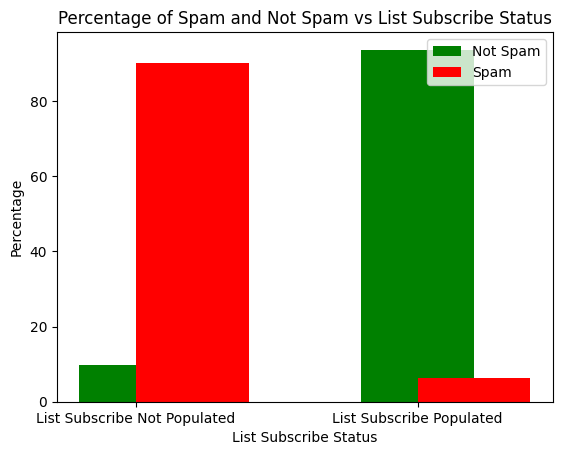

In [ ]:
# Check if 'List Subscribe Populated' is populated or not
email_df['list_subscribe_populated'] = email_df['list_subscribe'].apply(lambda x: 0 if pd.isna(x) or x == '[]' else 1)

# Create a crosstab to compare list_subscribe_populated with the label
crosstab = pd.crosstab(email_df['list_subscribe_populated'], email_df['label'], normalize='index')

# Calculate percentages for both scenarios
not_populated_not_spam_percentage = crosstab.loc[0, 0] * 100  # list_subscribe not populated, label 0 (not spam)
not_populated_spam_percentage = crosstab.loc[0, 1] * 100      # list_subscribe not populated, label 1 (spam)
populated_not_spam_percentage = crosstab.loc[1, 0] * 100      # list_subscribe populated, label 0 (not spam)
populated_spam_percentage = crosstab.loc[1, 1] * 100          # list_subscribe populated, label 1 (spam)

# Create a bar chart
labels = ['List Subscribe Not Populated', 'List Subscribe Populated']
not_spam_percentages = [not_populated_not_spam_percentage, populated_not_spam_percentage]
spam_percentages = [not_populated_spam_percentage, populated_spam_percentage]

x = range(len(labels))

plt.bar(x, not_spam_percentages, width=0.4, label='Not Spam', color='green', align='center')
plt.bar(x, spam_percentages, width=0.4, label='Spam', color='red', align='edge')

plt.xlabel('List Subscribe Status')
plt.ylabel('Percentage')
plt.title('Percentage of Spam and Not Spam vs List Subscribe Status')
plt.xticks(ticks=x, labels=labels)
plt.legend()

plt.show()

This proves that if the list_subscribe column has something in it, it is likely not a spam, meaning the label column will be 0. Therefore, the hypothesis would be correct.

## Hypothesis 3: Spam emails will not include mailto-anchor

In [ ]:
# Check if 'mailto_anchor' is populated
email_df['mailto_anchor_populated'] = email_df['mailto_anchor'].apply(lambda x: 0 if pd.isna(x) or x == '[]' else 1)

# Create a crosstab to compare mailto_populated with the label
crosstab = pd.crosstab(email_df['mailto_anchor_populated'], email_df['label'], normalize='index')

In [ ]:
# Calculate percentages
not_spam_percentage = crosstab[0] * 100  # label 0 means not spam
spam_percentage = crosstab[1] * 100      # label 1 means spam

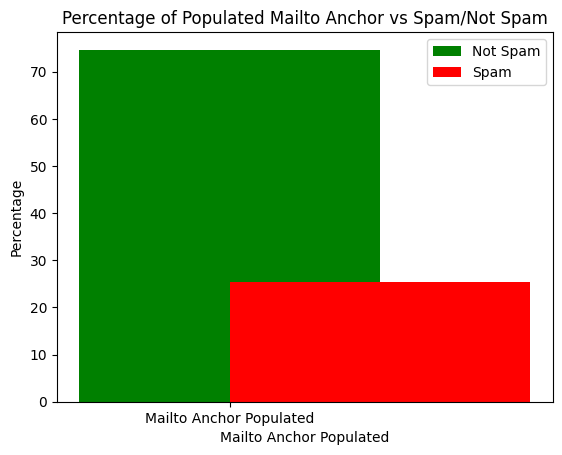

In [ ]:
# Create a bar chart
labels = ['Mailto Anchor Populated']
x = range(len(labels))

plt.bar(x, not_spam_percentage[1], width=0.4, label='Not Spam', color='green', align='center')
plt.bar(x, spam_percentage[1], width=0.4, label='Spam', color='red', align='edge')

plt.xlabel('Mailto Anchor Populated')
plt.ylabel('Percentage')
plt.title('Percentage of Populated Mailto Anchor vs Spam/Not Spam')
plt.xticks(ticks=x, labels=labels)
plt.legend()

To confirm whether if our hypothesis that the populated mailto-anchor (that has hyperlink) has a high correlation to non-spam, we compare with an unpopulated mailto-anchor to see if there is a contrast in results. If there is a contrast, means that our hypothesis is correct.


In [ ]:
# Check if 'mailto_anchor' is populated or not
email_df['mailto_populated'] = email_df['mailto_anchor'].apply(lambda x: 0 if pd.isna(x) or x == '[]' else 1)

# Create a crosstab to compare mailto_populated with the label
crosstab = pd.crosstab(email_df['mailto_populated'], email_df['label'], normalize='index')

In [ ]:
# Calculate percentages for both scenarios
not_populated_not_spam_percentage = crosstab.loc[0, 0] * 100  # mailto not populated, label 0 (not spam)
not_populated_spam_percentage = crosstab.loc[0, 1] * 100      # mailto not populated, label 1 (spam)
populated_not_spam_percentage = crosstab.loc[1, 0] * 100      # mailto populated, label 0 (not spam)
populated_spam_percentage = crosstab.loc[1, 1] * 100          # mailto populated, label 1 (spam)

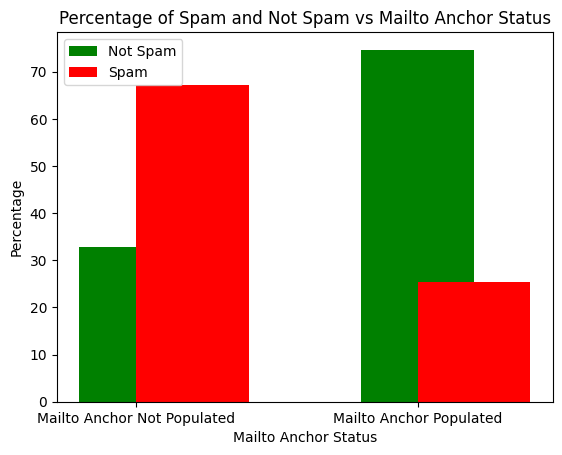

In [ ]:
# Create a bar chart
labels = ['Mailto Anchor Not Populated', 'Mailto Anchor Populated']
not_spam_percentages = [not_populated_not_spam_percentage, populated_not_spam_percentage]
spam_percentages = [not_populated_spam_percentage, populated_spam_percentage]

x = range(len(labels))

plt.bar(x, not_spam_percentages, width=0.4, label='Not Spam', color='green', align='center')
plt.bar(x, spam_percentages, width=0.4, label='Spam', color='red', align='edge')

plt.xlabel('Mailto Anchor Status')
plt.ylabel('Percentage')
plt.title('Percentage of Spam and Not Spam vs Mailto Anchor Status')
plt.xticks(ticks=x, labels=labels)
plt.legend()

plt.show()

This proves that if the mailto_anchor column has something in it, it is likely not a spam, meaning the label column will be 0. Hence, the hypothesis is correct.

### Correlation Analysis
Correlation Matrix for 'list_unsubscribe' feature against 'label'

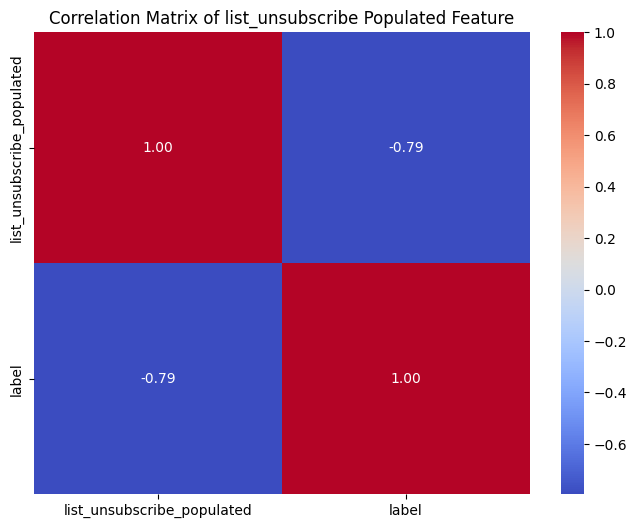

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check if 'list_unsubscribe' is populated and create the feature
email_df['list_unsubscribe_populated'] = email_df['list_unsubscribe'].apply(lambda x: 0 if pd.isna(x) or x == '[]' else 1)
features_to_include = ['list_unsubscribe_populated', 'label']

# Subset the DataFrame to include only the selected features
correlation_df = email_df[features_to_include]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of list_unsubscribe Populated Feature')
plt.show()

From the results above, there is a Strong Negative Correlation (-0.79) Between list_unsubscribe_populated and label:



*   The negative correlation of -0.79 suggests a strong inverse relationship between the presence of the list_unsubscribe header and the email being labeled as spam.

*   If the list_unsubscribe header is present (list_unsubscribe_populated = 1), the email is much more likely to be non-spam. On the other hand, if the header is missing, the email is more likely to be spam.


The strong negative correlation indicates that legitimate emails, which are typically not spam, often include a list_unsubscribe header. This aligns with common email practices where genuine senders provide an option to unsubscribe, complying with laws like the Spam Control Act (Singapore) and CAN-SPAM Act (US).

Perfect Positive Correlation (1.00) Within Each Feature:

*   The diagonal values of 1.00 represent the correlation of each feature with itself, which is naturally perfect and doesn't provide any additional insight beyond confirming that the features are consistent.

References on supporting journal articles:
- https://campaignrefinery.com/list-unsubscribe-header/
- https://www.postmastery.com/list-unsubscribe-header-critical-for-sustained-email-delivery/

---

# **Feature Engineering**
##### **1. mailto_anchor, mailto_header:**
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Create a binary categorical column indicating the presence of a mailto **(mailto_populated)**
##### **2. list-unsubscribe:**
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Create a binary categorical column indicating the presence of this mailing list **(list_unsubscribe_populated)**
##### **3. body:**
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Create a continuous column indicating the number of duplicates of the body **(body_duplicates)**
##### **4. authentication:**
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Create a binary categorical column that is 1 (true) if authenticated by at least one method **(is_authenticated)**
##### **5. received:**
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Create a continuous column indicating the number of received headers (number of relays) **(relay_count)**

### **1. mailto_populated**
#### After a comprehensive analysis of mailto, it was found that the presence of mailto in the email would help detect spam.

In [ ]:
def has_mailto(header, anchor):
    return 0 if not header and not anchor else 1

email_df['mailto_populated'] = email_df.apply(lambda row: has_mailto(row['mailto_header'], row['mailto_anchor']), axis=1)

We have already extracted useful features from the mailto attributes, and since the 'mailto_' columns have high cardinality, which is difficult to handle in modeling, they will be excluded from the existing dataset.

In [ ]:
email_df = email_df.drop(columns=['mailto_header', 'mailto_anchor', 'bigrams','unigram', 'mailto_anchor_populated'])

#### **- Correlation Test: Phi**

In [ ]:
from scipy.stats import contingency

def calculate_phi_and_pvalue(x, y):
    crosstab_result = contingency.crosstab(x, y)
    confusion_matrix = crosstab_result.count
    chi2, p_value, _, _ = contingency.chi2_contingency(confusion_matrix)
    n = np.sum(confusion_matrix)
    phi = (chi2 / n) ** 0.5

    if (confusion_matrix[0, 0] * confusion_matrix[1, 1] <
        confusion_matrix[0, 1] * confusion_matrix[1, 0]):
        phi = -phi

    return phi, p_value
phi_coefficient, p_value = calculate_phi_and_pvalue(email_df['mailto_populated'], email_df['label'])
print(f"Phi coefficient: {phi_coefficient}")
print(f"p-value: {p_value}")

Phi coefficient: -0.806690660211288
p-value: 0.0


It has a strong negative correlation with the label. In other words, as observed in the previous investigation, if the mailto information is absent, the likelihood of the email being spam increases.

### **2. list_unsubscribe_populated**
#### Among several mailing lists, list-unsubscribe is expected to be effective in mail detection (refer to the prev research)
#### This feature has already been created

In this study, the importance of the list-unsubscribe attribute is emphasized over other mailing lists. Therefore, other mailing lists will be excluded from the dataset.

In [ ]:
email_df = email_df.drop(columns=['list_subscribe', 'list_post', 'list_help', 'list_unsubscribe', 'list_subscribe_populated'])

#### **- Correlation Test: Phi**

In [ ]:
phi_coefficient, p_value = calculate_phi_and_pvalue(email_df['list_unsubscribe_populated'], email_df['label'])
print(f"Phi coefficient: {phi_coefficient}")
print(f"p-value: {p_value}")

Phi coefficient: -0.794968638381894
p-value: 0.0


It has a strong negative correlation with the label. In other words, as observed in the previous investigation, if the list-unsubscribe information is absent, the likelihood of the email being spam increases.

### **3. body_duplicates**
#### Spam begins with sending a large volume of emails with the same content.


In [ ]:
def create_body_duplicates_feature(df):
    non_empty_bodies = df[df['body'] != '']['body']
    body_counts = non_empty_bodies.value_counts()
    df['body_duplicates'] = df['body'].map(body_counts)
    df['body_duplicates'].fillna(0, inplace=True)
    df['body_duplicates'] = df['body_duplicates'].astype(int)
    return df

email_df = create_body_duplicates_feature(email_df)

C:\Users\X390\AppData\Local\Temp\ipykernel_14700\50123085.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['body_duplicates'].fillna(0, inplace=True)


### **- Correlation Test: Point-biserial**

In [ ]:
from scipy import stats

def calculate_point_biserial_correlation(df, continuous_vars, binary_var):
    results = {}
    for var in continuous_vars:
        correlation, p_value = stats.pointbiserialr(df[binary_var], df[var])
        results[var] = {'correlation': correlation, 'p_value': p_value}
    return results

correlation_results = calculate_point_biserial_correlation(email_df, ['body_duplicates'], 'label')
print("Point-biserial Correlation Results:")
for var, result in correlation_results.items():
    print(f"{var}:")
    print(f"  Correlation: {result['correlation']:.4f}")
    print(f"  P-value: {result['p_value']:.4f}")

Point-biserial Correlation Results:
body_duplicates:
  Correlation: 0.1359
  P-value: 0.0000


low correlation

### **4. is_authenticated**
#### The key factor is whether the data has authenticated records, so the existing authentication column will be engineered into is_authenticated.

In [ ]:
import ast

def check_authentication(x):
    try:
        auth_dict = ast.literal_eval(x)
        return 1 if any(auth_dict.values()) else 0
    except:
        return 0

email_df['is_authenticated'] = email_df['authentication'].apply(check_authentication)


In [ ]:
email_df = email_df.drop(columns=['authentication'])

<Figure size 1000x600 with 0 Axes>

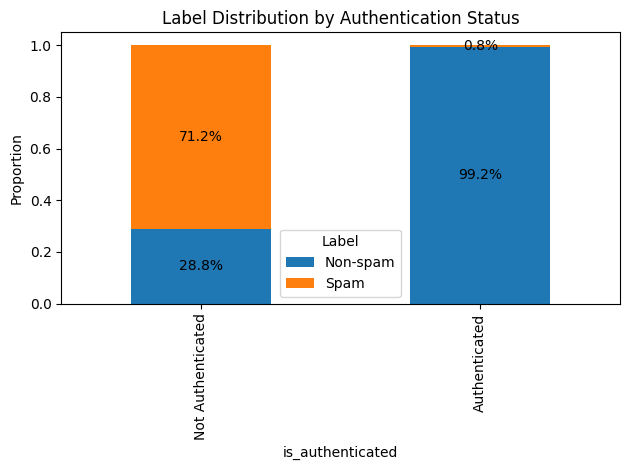

Label distribution when is_authenticated = 0:
label
0    0.287549
1    0.712451
Name: 0, dtype: float64

Label distribution when is_authenticated = 1:
label
0    0.991828
1    0.008172
Name: 1, dtype: float64

Overall is_authenticated distribution:
is_authenticated
0    0.933478
1    0.066522
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns

crosstab = pd.crosstab(email_df['is_authenticated'], email_df['label'], normalize='index')

plt.figure(figsize=(10, 6))
crosstab.plot(kind='bar', stacked=True)
plt.title('Label Distribution by Authentication Status')
plt.xlabel('is_authenticated')
plt.ylabel('Proportion')
plt.legend(title='Label', labels=['Non-spam', 'Spam'])
plt.xticks([0, 1], ['Not Authenticated', 'Authenticated'])

for i in range(len(crosstab)):
    for j in range(len(crosstab.columns)):
        plt.text(i, crosstab.iloc[i, j]/2 + (0 if j == 0 else crosstab.iloc[i, 0]),
                 f'{crosstab.iloc[i, j]:.1%}',
                 ha='center', va='center')

plt.tight_layout()
plt.show()

print("Label distribution when is_authenticated = 0:")
print(crosstab.loc[0])
print("\nLabel distribution when is_authenticated = 1:")
print(crosstab.loc[1])

auth_ratio = email_df['is_authenticated'].value_counts(normalize=True)
print("\nOverall is_authenticated distribution:")
print(auth_ratio)


Most of the data does not contain authentication-related information. However, looking at the graph, we can see that 99% of authenticated emails are ham (non-spam). This suggests that when authentication information is available, we can expect an improvement in spam detection capability.

#### **- Correlation Test: Phi**

In [ ]:
phi_coefficient, p_value = calculate_phi_and_pvalue(email_df['is_authenticated'], email_df['label'])
print(f"Phi coefficient: {phi_coefficient}")
print(f"p-value: {p_value}")

Phi coefficient: -0.3719404886349011
p-value: 0.0


It has a relatively weak correlation. This is thought to be due to the absence of authentication-related information in most of the data.

### **5. relay_count**

In [ ]:
import ast

def count_relays(received_str):
    try:
        received_list = ast.literal_eval(received_str)
        return len(received_list)
    except:
        return 0

email_df['relay_count'] = email_df['received'].apply(count_relays)

In [ ]:
email_df = email_df.drop(columns=['received'])

In [ ]:
correlation_results = calculate_point_biserial_correlation(email_df, ['relay_count'], 'label')
print("Point-biserial Correlation Results:")
for var, result in correlation_results.items():
    print(f"{var}:")
    print(f"  Correlation: {result['correlation']:.4f}")
    print(f"  P-value: {result['p_value']:.4f}")

Point-biserial Correlation Results:
relay_count:
  Correlation: -0.5861
  P-value: 0.0000


---

### **Correlation Test: Cramer's V**

#### **- x_spam_status**

In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

confusion_matrix = pd.crosstab(email_df['x_spam_status'], email_df['label'])

cramer_v = cramers_v(confusion_matrix)

print(f"Confusion Matrix:\n{confusion_matrix}\n")
print(f"Cramer's V: {cramer_v}")

Confusion Matrix:
label              0      1
x_spam_status              
no             17097    231
no_info         8041  49944
yes               82     24

Cramer's V: 0.7567870840193099


There is high correlation between x_spam_status and label

#### **- domain_comparison**

In [ ]:
confusion_matrix = pd.crosstab(email_df['domain_comparison'], email_df['label'])

cramer_v = cramers_v(confusion_matrix)

print(f"Confusion Matrix:\n{confusion_matrix}\n")
print(f"Cramer's V: {cramer_v}")

Confusion Matrix:
label                           0      1
domain_comparison                       
Domain mismatch             17250   8947
Exact domain match           4026  40921
Missing domain information      0     32
Subdomain match              3944    299

Cramer's V: 0.6435304821813542


There is moderately high correlation between x_spam_status and label

---

## **Data preprocessing (2)**
- RETURN_PATH, FROM: Remove unnecessary strings, leaving only the email addresses.

#### **RETURN_PATH, FROM: leave only email addresses**

In [ ]:
def extract_email(text):
    if pd.isna(text):
        return ''
    email_pattern = r'<([\w\.-]+@[\w\.-]+)>'
    match = re.search(email_pattern, text)
    if match:
        return match.group(1)
    email_pattern = r'([\w\.-]+@[\w\.-]+)'
    match = re.search(email_pattern, text)
    if match:
        return match.group(1)
    return ''

email_df['from_email'] = email_df['from'].apply(extract_email)
email_df['return_email'] = email_df['return_path'].apply(extract_email)

columns_to_drop = ['from', 'return_path']

email_df = email_df.drop(columns=columns_to_drop)

---

# **Data Transformation**
#### <li> Continuos columns: Scaling
#### <li> Multiple Categorical columns: One-hot Encoding
#### <li> Text columns: Vectorization:

In [ ]:
continuous_columns = ['body_duplicates', 'relay_count']
binary_categorical_columns= ['list_unsubscribe_populated', 'mailto_populated', 'is_authenticated']
multiple_categorical_columns = ['x_spam_status','domain_comparison']
text_columns = ['subject', 'body', 'from_email', 'return_email']

### **Scaling**

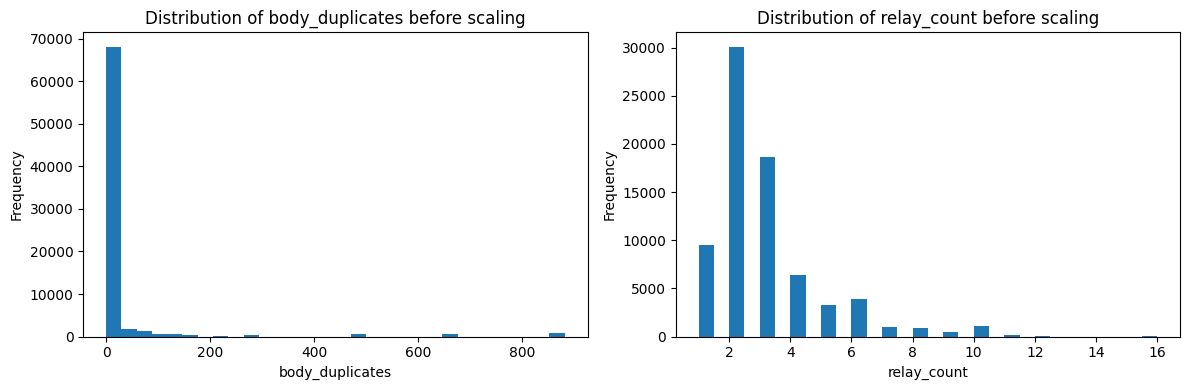

In [ ]:
import matplotlib.pyplot as plt
# Visualization of distribution before scaling
plt.figure(figsize=(12, 4))
for i, col in enumerate(continuous_columns):
    plt.subplot(1, 2, i+1)
    plt.hist(email_df[col], bins=30)
    plt.title(f'Distribution of {col} before scaling')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

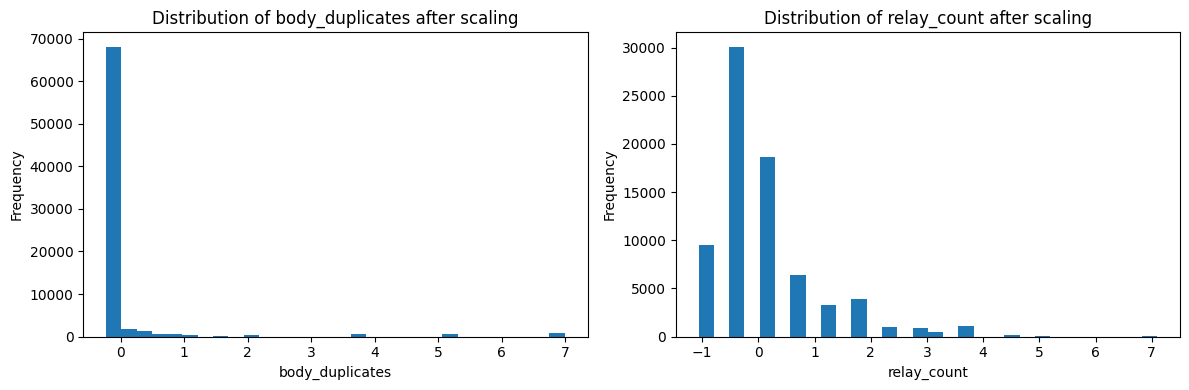

In [ ]:
from sklearn.preprocessing import StandardScaler

# scaling
scaler = StandardScaler()
email_df[continuous_columns] = scaler.fit_transform(email_df[continuous_columns])

# visualization
plt.figure(figsize=(12, 4))
for i, col in enumerate(continuous_columns):
    plt.subplot(1, 2, i+1)
    plt.hist(email_df[col], bins=30)
    plt.title(f'Distribution of {col} after scaling')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### **One-hot Encoding**

In [ ]:
email_df = pd.get_dummies(email_df, columns=['x_spam_status', 'domain_comparison'])
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   label                                         75419 non-null  int64 
 1   to                                            74843 non-null  object
 2   subject                                       75419 non-null  object
 3   body                                          75419 non-null  object
 4   list_unsubscribe_populated                    75419 non-null  int64 
 5   mailto_populated                              75419 non-null  int64 
 6   body_duplicates                               75419 non-null  int32 
 7   is_authenticated                              75419 non-null  int64 
 8   relay_count                                   75419 non-null  int64 
 9   from_email                                    75419 non-null  object
 10

In [ ]:
encoded_cols = ['x_spam_status_no', 'x_spam_status_no_info', 'x_spam_status_yes',
                'domain_comparison_Domain mismatch', 'domain_comparison_Exact domain match',
                'domain_comparison_Missing domain information', 'domain_comparison_Subdomain match']

def bool_to_binary(value):
    return 0 if value == False else 1

for col in encoded_cols:
    email_df[col] = email_df[col].apply(bool_to_binary)

In [ ]:
# update columns
binary_categorical_columns.extend(encoded_cols)
binary_categorical_columns

['list_unsubscribe_populated',
 'mailto_populated',
 'is_authenticated',
 'x_spam_status_no',
 'x_spam_status_no_info',
 'x_spam_status_yes',
 'domain_comparison_Domain mismatch',
 'domain_comparison_Exact domain match',
 'domain_comparison_Missing domain information',
 'domain_comparison_Subdomain match']

---

# **Feature Selection**

#### Columns not selected as input variables:
- ##### body_duplicates:
  The correlation values with the label are too low.
  
- ##### relay_count:
  While the correlation value is relatively high, it has a negative correlation with the label. This means that as the number of relays increases, the probability of spam decreases, which contradicts common sense. As this could cause confusion in model training, it is not selected.

- ##### to:
  Recipient information is generally not considered an important indicator in spam detection. Since spam is sent in large volumes to victims, analyzing the sender's information is likely to be more helpful.


### **Final columns to use for modeling**

In [ ]:
selected_df = email_df.copy()
selected_df = selected_df.drop(columns=['body_duplicates', 'relay_count', 'to'])
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 15 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   label                                         75419 non-null  int64 
 1   subject                                       75419 non-null  object
 2   body                                          75419 non-null  object
 3   list_unsubscribe_populated                    75419 non-null  int64 
 4   mailto_populated                              75419 non-null  int64 
 5   is_authenticated                              75419 non-null  int64 
 6   from_email                                    75419 non-null  object
 7   return_email                                  75419 non-null  object
 8   x_spam_status_no                              75419 non-null  int64 
 9   x_spam_status_no_info                         75419 non-null  int64 
 10

In [ ]:
selected_df['label'].value_counts(normalize=True)

label
1    0.665602
0    0.334398
Name: proportion, dtype: float64

# **Model Implementation**

- Logistic Regression
- Random Forest
- Dense Model

## **Basic Models**

#### **vectorization: max_feature**
Exploring the average, minimum, and maximum word count for text columns (body_cleaned, subject, from_email, return_email) to determine the appropriate max_features setting.
Max_features will be set to the top n most important words.

In [ ]:
def word_count(df, col):
    avg_count = df[col].apply(lambda x: len(x.split())).mean()
    min_count = df[col].apply(lambda x: len(x.split())).min()
    max_count = df[col].apply(lambda x: len(x.split())).max()
    return avg_count, min_count, max_count

for col in text_columns:
    avg_count, min_count, max_count = word_count(selected_df, col)
    print(f"<{col}>")
    print(f"Average word count: {avg_count}")
    print(f"Minimum word count: {min_count}")
    print(f"Maximum word count: {max_count}")
    print("\n")

<subject>
Average word count: 4.022991553852478
Minimum word count: 0
Maximum word count: 113


<body>
Average word count: 116.60833476975299
Minimum word count: 0
Maximum word count: 55865


<from_email>
Average word count: 0.9994033333775308
Minimum word count: 0
Maximum word count: 1


<return_email>
Average word count: 0.9999602222251687
Minimum word count: 0
Maximum word count: 1




From_email and return_email: These are essentially the email address, so the word count is estimated to be 1. Therefore, max_features is set to 1.
Subject and body: We need to examine the distribution in more detail to determine the appropriate settings.

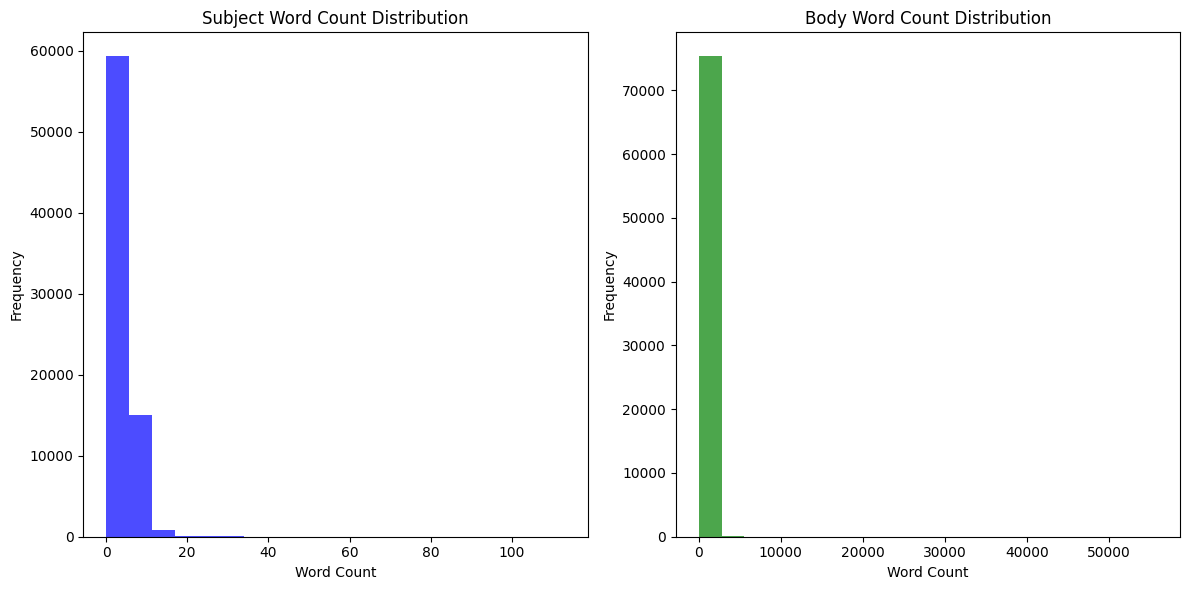

In [ ]:
# Copy dataframe to avoid modifying the original data
copy_df = selected_df.copy()

# Calculate word counts
copy_df['subject_word_count'] = copy_df['subject'].apply(lambda x: len(x.split()))
copy_df['body_word_count'] = copy_df['body'].apply(lambda x: len(x.split()))

# Plotting the distributions
plt.figure(figsize=(12, 6))

# Subject word count distribution
plt.subplot(1, 2, 1)
plt.hist(copy_df['subject_word_count'], bins=20, color='blue', alpha=0.7)
plt.title('Subject Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Body word count distribution
plt.subplot(1, 2, 2)
plt.hist(copy_df['body_word_count'], bins=20, color='green', alpha=0.7)
plt.title('Body Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

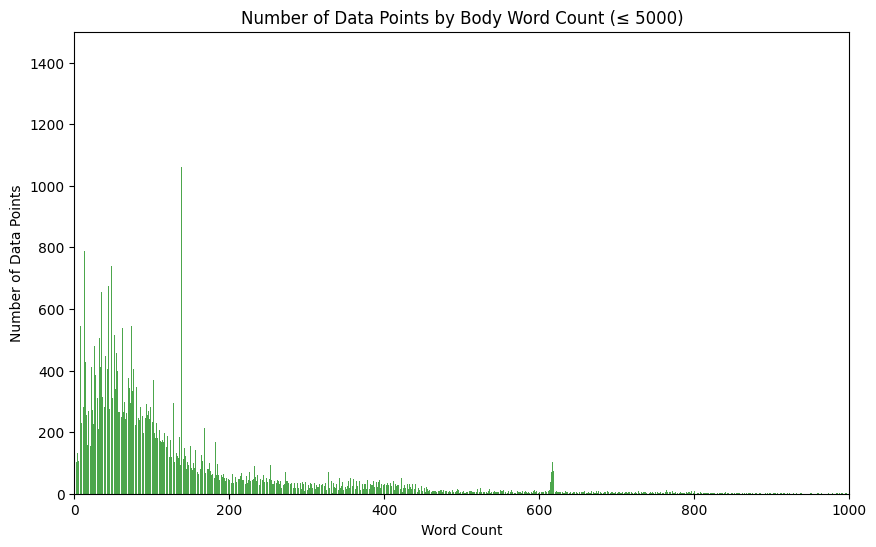

In [ ]:
# Calculate word counts
body_word_count_dist = copy_df['body_word_count'].value_counts().sort_index()

# Filter to show only word counts less than or equal to 5000
#filtered_body_word_count_dist = body_word_count_dist[body_word_count_dist.index <= 1000]

# Plot the filtered distribution
plt.figure(figsize=(10, 6))
plt.bar(body_word_count_dist.index, body_word_count_dist.values, color='green', alpha=0.7)
plt.title('Number of Data Points by Body Word Count (≤ 5000)')
plt.xlabel('Word Count')
plt.ylabel('Number of Data Points')

plt.xlim(0, 1000) # not include when 0
plt.ylim(0, 1500)

plt.show()

Subject: Experiment with max_features under 100. <br>
Body_cleaned: The distribution variance is very large. To account for this, we'll experiment with max_features under 1000, using word scaling based on word count.

#### **Train, Validation, Test set split**
Training, validation, and test set split (6:2:2): Stratified splitting is used to ensure that the label proportions of the original dataset are maintained within each subset. As a result, the label proportions are preserved in the training set, validation set, and test set.

In [ ]:
from sklearn.model_selection import train_test_split

X = selected_df.drop('label', axis=1)
y = selected_df['label']

# Holdout validation with stratification
# Split the data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split train+validation into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Now let's calculate the label distribution
train_dist_actual = Counter(y_train)
val_dist_actual = Counter(y_val)
test_dist_actual = Counter(y_test)

train_dist_actual, val_dist_actual, test_dist_actual

(Counter({1: 30119, 0: 15132}),
 Counter({1: 10040, 0: 5044}),
 Counter({1: 10040, 0: 5044}))

### **- Logistic Regression**
- The max_features parameter was set after multiple experiments to avoid overfitting with values of 10, 100, 1, and 1.
- The C value was adjusted to control the model's complexity; a lower value reduces complexity and helps prevent overfitting, with 0.01 being chosen.
- The class_weight was set to balanced, applying weights of 0.75 and 1.5 to class 1 and class 0, respectively, to address the class imbalance issue.

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing pipeline: vectorization
preprocessor = ColumnTransformer(
    transformers=[
        ('subject_tfidf', TfidfVectorizer(max_features=10, stop_words='english'), 'subject'),
        ('body_tfidf', TfidfVectorizer(max_features=100, stop_words='english'), 'body'),
        ('from_email_tfidf', TfidfVectorizer(max_features=1), 'from_email'),
        ('return_email_tfidf', TfidfVectorizer(max_features=1), 'return_email'),
        ('bin_cat', 'passthrough', binary_categorical_columns),
    ]
)

#----------------------------------------------------------------------------------------------------------

# Logistic Regression Pipeline
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000, random_state=42))
])

# Train and evaluate the model
try:
    # Fit the model
    log_reg_pipeline.fit(X_train, y_train)

    # Make predictions on validation set
    y_val_pred = log_reg_pipeline.predict(X_val)
    y_val_pred_proba = log_reg_pipeline.predict_proba(X_val)[:, 1]
    #validation set Evaluation
    val_auc_score = roc_auc_score(y_val, y_val_pred_proba)

    print("\nLogistic Regression Validation Results:")
    print(f"Validation AUC Score: {val_auc_score:.4f}")

    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Make predictions on test set
    y_test_pred = log_reg_pipeline.predict(X_test)
    y_test_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

    # test set Evaluation
    test_auc_score = roc_auc_score(y_test, y_test_pred_proba)

    print("\nLogistic Regression Test Results:")
    print(f"Test AUC Score: {test_auc_score:.4f}")

    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred))

except Exception as e:
    print("\nError in Logistic Regression processing:")
    print(str(e))


Logistic Regression Validation Results:
Validation AUC Score: 0.9808

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5044
           1       0.95      0.97      0.96     10040

    accuracy                           0.95     15084
   macro avg       0.94      0.94      0.94     15084
weighted avg       0.95      0.95      0.95     15084


Logistic Regression Test Results:
Test AUC Score: 0.9826

Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5044
           1       0.95      0.97      0.96     10040

    accuracy                           0.95     15084
   macro avg       0.94      0.94      0.94     15084
weighted avg       0.95      0.95      0.95     15084



In [ ]:
lr_results = {
    'dataset': [],
    'auc_score': [],
    'classification_report': []
}

lr_results['dataset'].append('Validation')
lr_results['auc_score'].append(val_auc_score)
lr_results['classification_report'].append(classification_report(y_val, y_val_pred))

lr_results['dataset'].append('Test')
lr_results['auc_score'].append(test_auc_score)
lr_results['classification_report'].append(classification_report(y_test, y_test_pred))

When the Holdout method is combined with Stratified splitting, the data distribution becomes very similar across the training, validation, and test datasets. This results in the model performing similarly across these datasets. Additionally, since the AUC score on the test set is higher than that on the training and validation sets, the potential for overfitting is minimized.

### **- Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', n_estimators=100,
                                          max_depth=3, min_samples_leaf=5,  random_state=42))
])

# Train and evaluate the model
try:
    # Fit the model
    rf_pipeline.fit(X_train, y_train)

    # Make predictions on validation set
    y_val_pred = rf_pipeline.predict(X_val)
    y_val_pred_proba = rf_pipeline.predict_proba(X_val)[:, 1]
    #validation set Evaluation
    val_auc_score = roc_auc_score(y_val, y_val_pred_proba)

    print("\nRandom Forest Validation Results:")
    print(f"Validation AUC Score: {val_auc_score:.4f}")

    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Make predictions on test set
    y_test_pred = log_reg_pipeline.predict(X_test)
    y_test_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

    # test set Evaluation
    test_auc_score = roc_auc_score(y_test, y_test_pred_proba)

    print("\nRandom Forest Test Results:")
    print(f"Test AUC Score: {test_auc_score:.4f}")

    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred))

except Exception as e:
    print("\nError in Random Forest processing:")
    print(str(e))



Random Forest Validation Results:
Validation AUC Score: 0.9763

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      5044
           1       0.94      0.99      0.96     10040

    accuracy                           0.95     15084
   macro avg       0.96      0.93      0.94     15084
weighted avg       0.95      0.95      0.95     15084


Random Forest Test Results:
Test AUC Score: 0.9826

Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5044
           1       0.95      0.97      0.96     10040

    accuracy                           0.95     15084
   macro avg       0.94      0.94      0.94     15084
weighted avg       0.95      0.95      0.95     15084



In [ ]:
rf_results = {
    'dataset': [],
    'auc_score': [],
    'classification_report': []
}

rf_results['dataset'].append('Validation')
rf_results['auc_score'].append(val_auc_score)
rf_results['classification_report'].append(classification_report(y_val, y_val_pred))

rf_results['dataset'].append('Test')
rf_results['auc_score'].append(test_auc_score)
rf_results['classification_report'].append(classification_report(y_test, y_test_pred))

### **- Dense Model**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

def tfidf_vectorize(train_data, val_data, test_data, max_features):
    vectorizers = {}
    train_vectors = []
    val_vectors = []
    test_vectors = []

    for column in ['subject', 'body', 'from_email', 'return_email']:
        vectorizer = TfidfVectorizer(max_features=max_features[column])
        train_vector = vectorizer.fit_transform(train_data[column]).toarray()
        val_vector = vectorizer.transform(val_data[column]).toarray()
        test_vector = vectorizer.transform(test_data[column]).toarray()

        vectorizers[column] = vectorizer
        train_vectors.append(train_vector)
        val_vectors.append(val_vector)
        test_vectors.append(test_vector)

    train_vectors.append(train_data[binary_categorical_columns].values)
    val_vectors.append(val_data[binary_categorical_columns].values)
    test_vectors.append(test_data[binary_categorical_columns].values)

    return vectorizers, train_vectors, val_vectors, test_vectors

def create_dense_model(input_shapes):
    inputs = []
    dense_layers = []

    for shape in input_shapes:
        input_layer = Input(shape=shape)
        inputs.append(input_layer)
        dense_layer = Dense(64, activation='relu')(input_layer)
        dense_layer = Dropout(0.5)(dense_layer)
        dense_layers.append(dense_layer)

    concatenated = Concatenate()(dense_layers)
    dense_layer = Dense(64, activation='relu')(concatenated)
    dense_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

max_features = {
    'subject': 10,
    'body': 100,
    'from_email': 1,
    'return_email': 1
}

vectorizers, X_train_vectorized, X_val_vectorized, X_test_vectorized = tfidf_vectorize(X_train, X_val, X_test, max_features)

input_shapes = [X.shape[1:] for X in X_train_vectorized]
model = create_dense_model(input_shapes)

history = model.fit(
    X_train_vectorized, y_train,
    validation_data=(X_val_vectorized, y_val),
    epochs=10, batch_size=32, verbose=1,
    class_weight=class_weight_dict
)

y_val_pred_proba = model.predict(X_val_vectorized)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)
val_auc_score = roc_auc_score(y_val, y_val_pred_proba)

print("\nDense Validation Results:")
print(f"Validation AUC Score: {val_auc_score:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

y_test_pred_proba = model.predict(X_test_vectorized)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)
test_auc_score = roc_auc_score(y_test, y_test_pred_proba)

print("\Dense Test Results:")
print(f"Test AUC Score: {test_auc_score:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

Epoch 1/10
1415/1415 [==============================] - 15s 9ms/step - loss: 0.1653 - accuracy: 0.9500 - val_loss: 0.0901 - val_accuracy: 0.9722
Epoch 2/10
1415/1415 [==============================] - 11s 8ms/step - loss: 0.1061 - accuracy: 0.9697 - val_loss: 0.0796 - val_accuracy: 0.9772
Epoch 3/10
1415/1415 [==============================] - 10s 7ms/step - loss: 0.0929 - accuracy: 0.9745 - val_loss: 0.0689 - val_accuracy: 0.9804
Epoch 4/10
1415/1415 [==============================] - 11s 7ms/step - loss: 0.0829 - accuracy: 0.9775 - val_loss: 0.0634 - val_accuracy: 0.9812
Epoch 5/10
1415/1415 [==============================] - 10s 7ms/step - loss: 0.0781 - accuracy: 0.9783 - val_loss: 0.0588 - val_accuracy: 0.9819
Epoch 6/10
1415/1415 [==============================] - 10s 7ms/step - loss: 0.0758 - accuracy: 0.9789 - val_loss: 0.0619 - val_accuracy: 0.9810
Epoch 7/10
1415/1415 [==============================] - 10s 7ms/step - loss: 0.0715 - accuracy: 0.9801 - val_loss: 0.0574 - val_ac

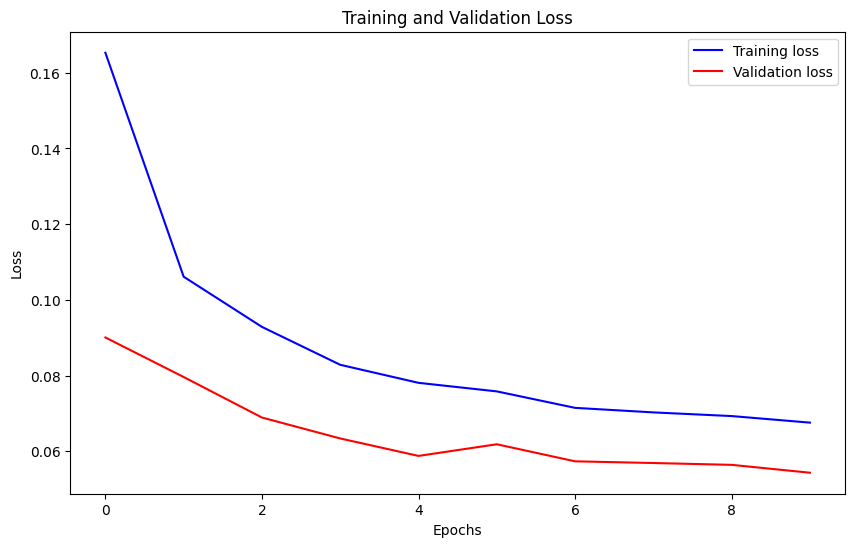

In [ ]:
def plot_train_val_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_train_val_loss(history)

In [ ]:
dense_results = {
    'dataset': [],
    'auc_score': [],
    'classification_report': []
}

dense_results['dataset'].append('Validation')
dense_results['auc_score'].append(val_auc_score)
dense_results['classification_report'].append(classification_report(y_val, y_val_pred))

dense_results['dataset'].append('Test')
dense_results['auc_score'].append(test_auc_score)
dense_results['classification_report'].append(classification_report(y_test, y_test_pred))

## **Hyper Parameter Tuning**

### **- Logistic Regression**

In [ ]:
from sklearn.model_selection import GridSearchCV

log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Define parameter grid for grid search
param_grid = {
    'preprocessor__subject_tfidf__max_features': [10, 20],
    'preprocessor__body_tfidf__max_features': [100, 200],
    'classifier__C': [0.01, 0.1, 1],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__max_iter': [1000, 2000]
}

# Create GridSearchCV object
grid_search = GridSearchCV(log_reg_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Dictionary to store results
tuned_lr_results = {
    'dataset': [],
    'auc_score': [],
    'classification_report': [],
    'best_params': None
}

try:
    # Perform grid search on training set
    print("Performing GridSearchCV on training set...")
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Save best parameters
    tuned_lr_results['best_params'] = grid_search.best_params_
    print("\nBest parameters:")
    print(tuned_lr_results['best_params'])

    # Predictions on validation set
    print("\nEvaluating performance on validation set...")
    y_val_pred = best_model.predict(X_val)
    y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

    # Evaluate validation set
    val_auc_score = roc_auc_score(y_val, y_val_pred_proba)

    print(f"Validation AUC score: {val_auc_score:.4f}")

    print("\nValidation classification report:")
    val_classification_report = classification_report(y_val, y_val_pred)
    print(val_classification_report)

    # Save validation results
    tuned_lr_results['dataset'].append('Validation')
    tuned_lr_results['auc_score'].append(val_auc_score)
    tuned_lr_results['classification_report'].append(val_classification_report)

    # Predictions on test set
    print("\nEvaluating final performance on test set...")
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate test set
    test_auc_score = roc_auc_score(y_test, y_test_pred_proba)

    print(f"Test AUC score: {test_auc_score:.4f}")

    print("\nTest classification report:")
    test_classification_report = classification_report(y_test, y_test_pred)
    print(test_classification_report)

    # Save test results
    tuned_lr_results['dataset'].append('Test')
    tuned_lr_results['auc_score'].append(test_auc_score)
    tuned_lr_results['classification_report'].append(test_classification_report)

except Exception as e:
    print("\nError occurred during logistic regression processing:")
    print(str(e))

Performing GridSearchCV on training set...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters:
{'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 1000, 'preprocessor__body_tfidf__max_features': 200, 'preprocessor__subject_tfidf__max_features': 20}

Evaluating performance on validation set...
Validation AUC score: 0.9925

Validation classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5044
           1       0.97      0.98      0.98     10040

    accuracy                           0.97     15084
   macro avg       0.96      0.96      0.96     15084
weighted avg       0.97      0.97      0.97     15084


Evaluating final performance on test set...
Test AUC score: 0.9934

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5044
           1       0.98      0.98      0.98     

### **- Random Forest**

In [ ]:
# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for grid search
param_grid = {
    'preprocessor__subject_tfidf__max_features': [10, 20],
    'preprocessor__body_tfidf__max_features': [100, 200],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__min_samples_leaf': [3, 5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Dictionary to store results
tuned_rf_results = {
    'dataset': [],
    'auc_score': [],
    'classification_report': [],
    'best_params': None
}

try:
    # Perform grid search on training set
    print("Performing GridSearchCV on training set...")
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Save best parameters
    tuned_rf_results['best_params'] = grid_search.best_params_
    print("\nBest parameters:")
    print(tuned_rf_results['best_params'])

    # Make predictions on validation set
    y_val_pred = best_model.predict(X_val)
    y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

    # Validation set Evaluation
    val_auc_score = roc_auc_score(y_val, y_val_pred_proba)

    print("\nRandom Forest Validation Results:")
    print(f"Validation AUC Score: {val_auc_score:.4f}")

    print("\nValidation Classification Report:")
    val_classification_report = classification_report(y_val, y_val_pred)
    print(val_classification_report)

    # Save validation results
    tuned_rf_results['dataset'].append('Validation')
    tuned_rf_results['auc_score'].append(val_auc_score)
    tuned_rf_results['classification_report'].append(val_classification_report)

    # Make predictions on test set
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Test set Evaluation
    test_auc_score = roc_auc_score(y_test, y_test_pred_proba)

    print("\nRandom Forest Test Results:")
    print(f"Test AUC Score: {test_auc_score:.4f}")

    print("\nTest Classification Report:")
    test_classification_report = classification_report(y_test, y_test_pred)
    print(test_classification_report)

    # Save test results
    tuned_rf_results['dataset'].append('Test')
    tuned_rf_results['auc_score'].append(test_auc_score)
    tuned_rf_results['classification_report'].append(test_classification_report)

except Exception as e:
    print("\nError in Random Forest processing:")
    print(str(e))


Performing GridSearchCV on training set...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters:
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 100, 'preprocessor__body_tfidf__max_features': 200, 'preprocessor__subject_tfidf__max_features': 20}

Random Forest Validation Results:
Validation AUC Score: 0.9812

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      5044
           1       0.94      1.00      0.97     10040

    accuracy                           0.96     15084
   macro avg       0.97      0.94      0.95     15084
weighted avg       0.96      0.96      0.96     15084


Random Forest Test Results:
Test AUC Score: 0.9832

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      5044
           1       0.94      1.00      0.97     10040

    accuracy 

### **- Dense Model**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

def create_dense_model(input_shapes, dense_units=64, dropout_rate=0.5):
    inputs = []
    dense_layers = []

    for shape in input_shapes:
        input_layer = Input(shape=shape)
        inputs.append(input_layer)
        dense_layer = Dense(dense_units, activation='relu')(input_layer)
        dense_layer = Dropout(dropout_rate)(dense_layer)
        dense_layers.append(dense_layer)

    concatenated = Concatenate()(dense_layers)
    dense_layer = Dense(dense_units, activation='relu')(concatenated)
    dense_layer = Dropout(dropout_rate)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define parameter grid
param_grid = {
    'dense_units': [32, 64],
    'dropout_rate': [0.5, 0.7],
    'batch_size': [32, 64]
}

# Dictionary to store results
tuned_dense_results = {
    'dataset': [],
    'auc_score': [],
    'classification_report': [],
    'best_params': None
}

best_val_auc = 0
best_params = None

try:
    print("Performing manual hyperparameter search...")
    for dense_units in param_grid['dense_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                print(f"\nTrying: dense_units={dense_units}, dropout_rate={dropout_rate}, batch_size={batch_size}")

                model = create_dense_model(input_shapes, dense_units, dropout_rate)

                history = model.fit(
                    X_train_vectorized, y_train,
                    validation_data=(X_val_vectorized, y_val),
                    epochs=10, batch_size=batch_size, verbose=0,
                    class_weight=class_weight_dict
                )

                y_val_pred = model.predict(X_val_vectorized)
                val_auc_score = roc_auc_score(y_val, y_val_pred)

                print(f"Validation AUC Score: {val_auc_score:.4f}")

                if val_auc_score > best_val_auc:
                    best_val_auc = val_auc_score
                    best_params = {
                        'dense_units': dense_units,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size
                    }

    print("\nBest parameters:")
    print(best_params)
    tuned_dense_results['best_params'] = best_params

    # Train final model with best parameters
    best_model = create_dense_model(input_shapes, best_params['dense_units'], best_params['dropout_rate'])
    best_model.fit(
        X_train_vectorized, y_train,
        validation_data=(X_val_vectorized, y_val),
        epochs=10, batch_size=best_params['batch_size'], verbose=0,
        class_weight=class_weight_dict
    )

    # Validation set Evaluation
    y_val_pred = best_model.predict(X_val_vectorized)
    val_auc_score = roc_auc_score(y_val, y_val_pred)

    print("\nDense Model Validation Results:")
    print(f"Validation AUC Score: {val_auc_score:.4f}")

    print("\nValidation Classification Report:")
    val_classification_report = classification_report(y_val, (y_val_pred > 0.5).astype(int))
    print(val_classification_report)

    tuned_dense_results['dataset'].append('Validation')
    tuned_dense_results['auc_score'].append(val_auc_score)
    tuned_dense_results['classification_report'].append(val_classification_report)

    # Test set Evaluation
    y_test_pred = best_model.predict(X_test_vectorized)
    test_auc_score = roc_auc_score(y_test, y_test_pred)

    print("\nDense Model Test Results:")
    print(f"Test AUC Score: {test_auc_score:.4f}")

    print("\nTest Classification Report:")
    test_classification_report = classification_report(y_test, (y_test_pred > 0.5).astype(int))
    print(test_classification_report)

    tuned_dense_results['dataset'].append('Test')
    tuned_dense_results['auc_score'].append(test_auc_score)
    tuned_dense_results['classification_report'].append(test_classification_report)

except Exception as e:
    print("\nError in Dense Model processing:")
    print(str(e))

Performing manual hyperparameter search...

Trying: dense_units=32, dropout_rate=0.5, batch_size=32
472/472 [==============================] - 2s 4ms/step
Validation AUC Score: 0.9955

Trying: dense_units=32, dropout_rate=0.5, batch_size=64
472/472 [==============================] - 6s 4ms/step
Validation AUC Score: 0.9955

Trying: dense_units=32, dropout_rate=0.7, batch_size=32
472/472 [==============================] - 4s 6ms/step
Validation AUC Score: 0.9921

Trying: dense_units=32, dropout_rate=0.7, batch_size=64
472/472 [==============================] - 2s 4ms/step
Validation AUC Score: 0.9918

Trying: dense_units=64, dropout_rate=0.5, batch_size=32
472/472 [==============================] - 4s 6ms/step
Validation AUC Score: 0.9954

Trying: dense_units=64, dropout_rate=0.5, batch_size=64
472/472 [==============================] - 2s 4ms/step
Validation AUC Score: 0.9962

Trying: dense_units=64, dropout_rate=0.7, batch_size=32
472/472 [==============================] - 2s 4ms/step

# **Evaluation**

### logistic regression

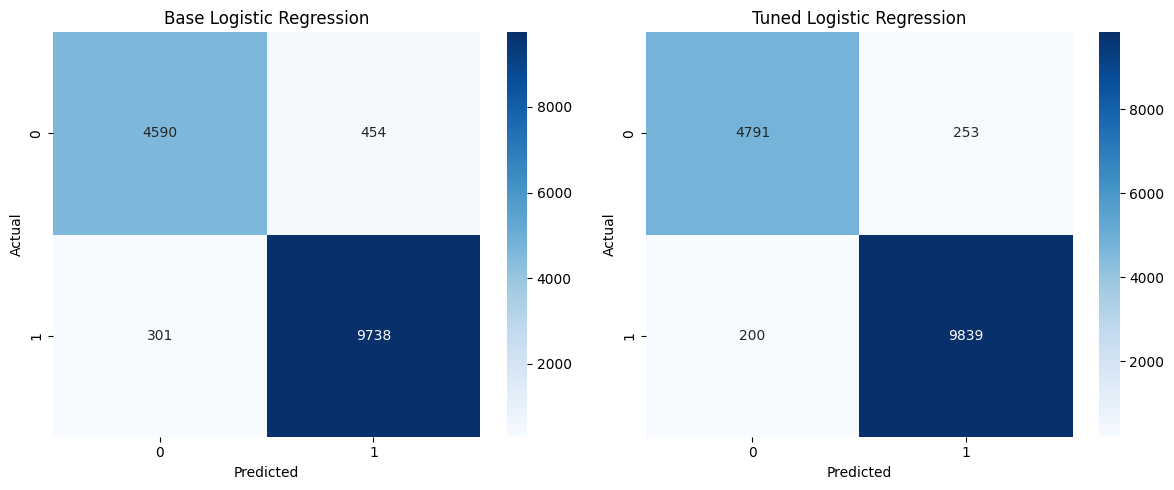

Base Model Test AUC: 0.9826
Tuned Model Test AUC: 0.9934


In [ ]:
import seaborn as sns

def parse_classification_report(report):
    lines = report.split('\n')
    class_data = {}
    for line in lines[2:-5]:
        row_data = line.split()
        if len(row_data) == 5:
            class_name = row_data[0]
            metrics = {
                'precision': float(row_data[1]),
                'recall': float(row_data[2]),
                'f1-score': float(row_data[3]),
                'support': int(row_data[4])
            }
            class_data[class_name] = metrics
    return class_data

def classification_report_to_confusion_matrix(report):
    data = parse_classification_report(report)
    tn = int(data['0']['support'] * data['0']['recall'])
    fp = int(data['0']['support'] - tn)
    fn = int(data['1']['support'] - data['1']['support'] * data['1']['recall'])
    tp = int(data['1']['support'] * data['1']['recall'])
    return np.array([[tn, fp], [fn, tp]])

def plot_confusion_matrix(cm, ax, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

base_test_report = lr_results['classification_report'][1]
tuned_test_report = tuned_lr_results['classification_report'][1]

cm_base = classification_report_to_confusion_matrix(base_test_report)
cm_tuned = classification_report_to_confusion_matrix(tuned_test_report)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(cm_base, ax1, 'Base Logistic Regression')
plot_confusion_matrix(cm_tuned, ax2, 'Tuned Logistic Regression')

plt.tight_layout()
plt.show()

print(f"Base Model Test AUC: {lr_results['auc_score'][1]:.4f}")
print(f"Tuned Model Test AUC: {tuned_lr_results['auc_score'][1]:.4f}")

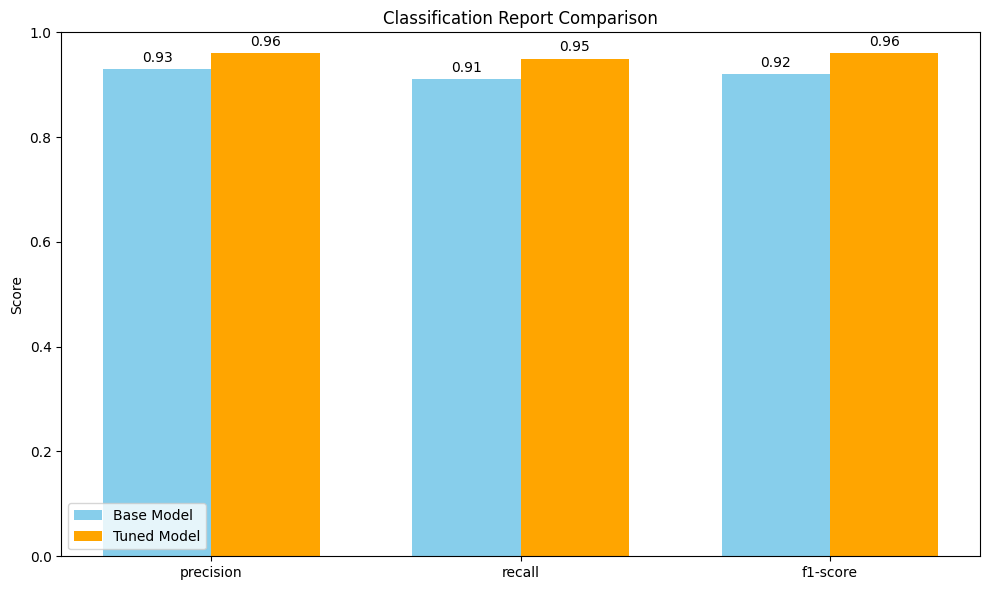

In [ ]:
def parse_classification_report2(report):
    lines = report.split('\n')
    data = {}
    for line in lines[2:-3]:
        row = line.split()
        if len(row) >= 5:
            class_name = row[0]
            if class_name not in ['accuracy', 'macro', 'weighted']:
                data['precision'] = float(row[1])
                data['recall'] = float(row[2])
                data['f1-score'] = float(row[3])
                break
    return data

base_data = parse_classification_report2(lr_results['classification_report'][1])
tuned_data = parse_classification_report2(tuned_lr_results['classification_report'][1])

metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, [base_data[m] for m in metrics], width, label='Base Model', color='skyblue')
rects2 = ax.bar(x + width/2, [tuned_data[m] for m in metrics], width, label='Tuned Model', color='orange')

ax.set_ylabel('Score')
ax.set_title('Classification Report Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

### Random Forest

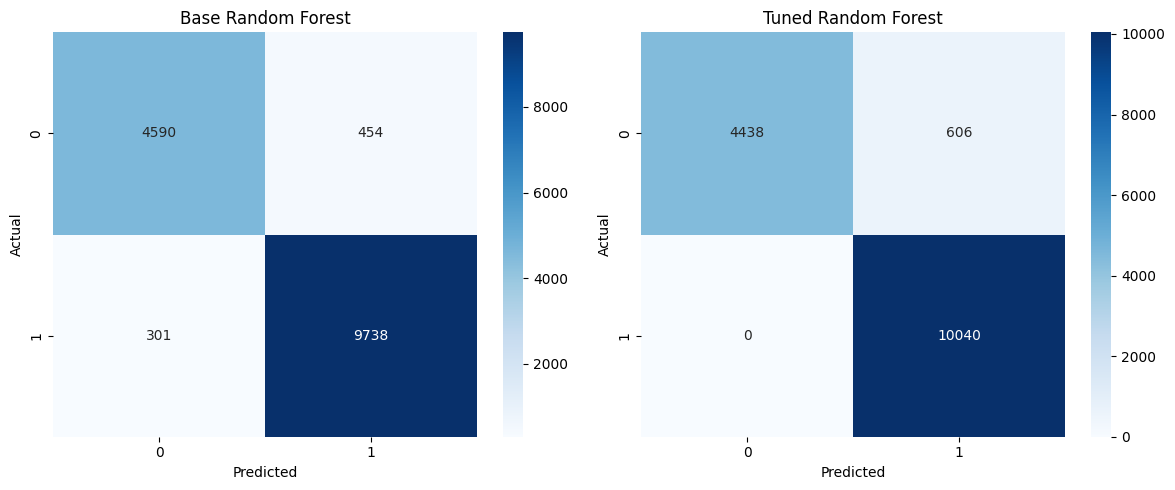

Base Model Test AUC: 0.9826
Tuned Model Test AUC: 0.9832


In [ ]:
base_test_report = rf_results['classification_report'][1]
tuned_test_report = tuned_rf_results['classification_report'][1]

cm_base = classification_report_to_confusion_matrix(base_test_report)
cm_tuned = classification_report_to_confusion_matrix(tuned_test_report)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(cm_base, ax1, 'Base Random Forest')
plot_confusion_matrix(cm_tuned, ax2, 'Tuned Random Forest')

plt.tight_layout()
plt.show()

print(f"Base Model Test AUC: {rf_results['auc_score'][1]:.4f}")
print(f"Tuned Model Test AUC: {tuned_rf_results['auc_score'][1]:.4f}")

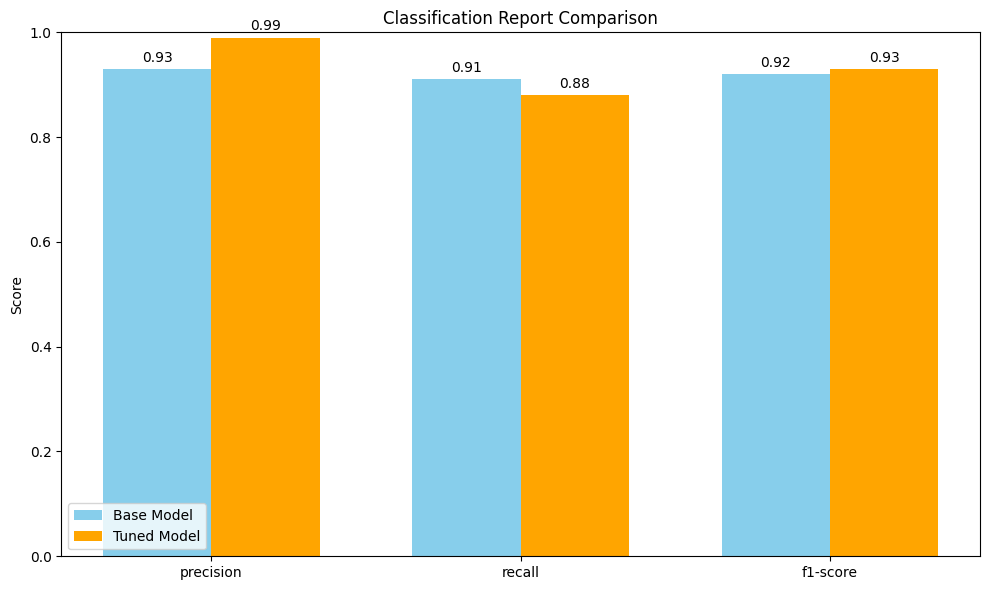

In [ ]:
base_data = parse_classification_report2(rf_results['classification_report'][1])
tuned_data = parse_classification_report2(tuned_rf_results['classification_report'][1])

metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, [base_data[m] for m in metrics], width, label='Base Model', color='skyblue')
rects2 = ax.bar(x + width/2, [tuned_data[m] for m in metrics], width, label='Tuned Model', color='orange')

ax.set_ylabel('Score')
ax.set_title('Classification Report Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

### Dense Model

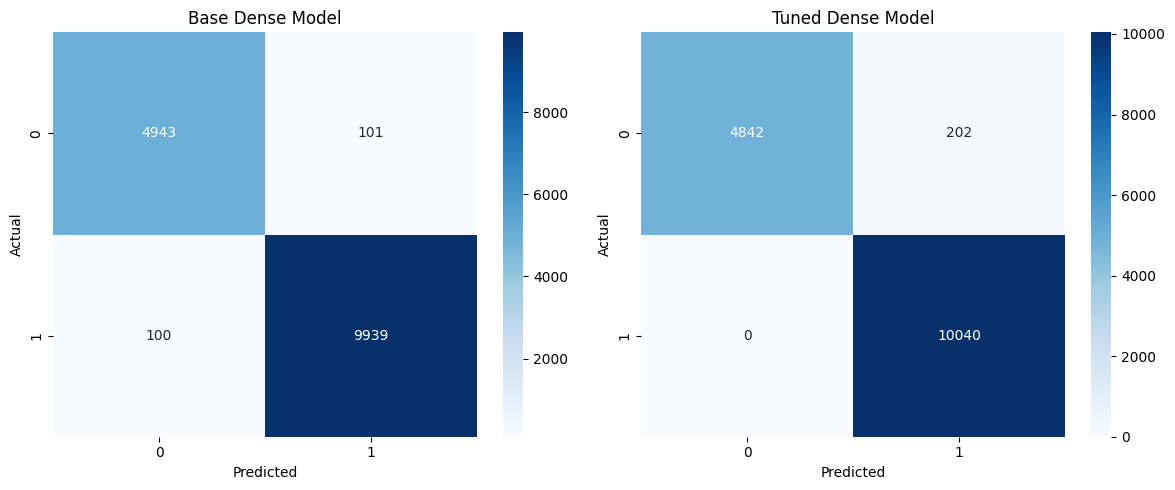

Base Model Test AUC: 0.9966
Tuned Model Test AUC: 0.9967


In [ ]:
base_test_report = dense_results['classification_report'][1]
tuned_test_report = tuned_dense_results['classification_report'][1]

cm_base = classification_report_to_confusion_matrix(base_test_report)
cm_tuned = classification_report_to_confusion_matrix(tuned_test_report)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(cm_base, ax1, 'Base Dense Model')
plot_confusion_matrix(cm_tuned, ax2, 'Tuned Dense Model')

plt.tight_layout()
plt.show()

print(f"Base Model Test AUC: {dense_results['auc_score'][1]:.4f}")
print(f"Tuned Model Test AUC: {tuned_dense_results['auc_score'][1]:.4f}")

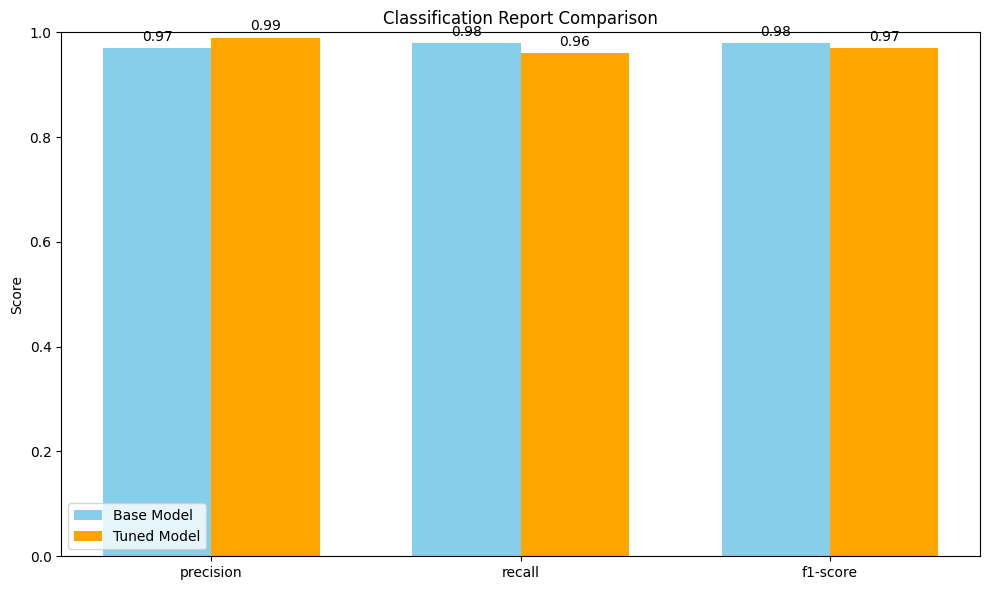

In [ ]:
base_data = parse_classification_report2(dense_results['classification_report'][1])
tuned_data = parse_classification_report2(tuned_dense_results['classification_report'][1])

metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, [base_data[m] for m in metrics], width, label='Base Model', color='skyblue')
rects2 = ax.bar(x + width/2, [tuned_data[m] for m in metrics], width, label='Tuned Model', color='orange')

ax.set_ylabel('Score')
ax.set_title('Classification Report Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

add your further evaluation analysis

# **Conclusion**
The models were tuned based on the ROC AUC score. As a result, while there are improvements in the AUC score, the precision, recall, and f1-score may sometimes decrease. The following explains the criteria for the AUC score and the scoring basis for confusion matrix and classification report.

- ROC AUC Score:<br>
The AUC (Area Under the Curve) of the ROC (Receiver Operating Characteristic) curve is a metric for evaluating the performance of binary classification models.<br>
The AUC score ranges from 0 to 1, with scores closer to 1 indicating better model performance.<br>
It represents the overall performance of the model across all threshold values.<br>
It is less sensitive to class imbalance problems.<br><br>
- Confusion Matrix and Classification Report:<br>
These provide a more detailed evaluation of model performance at specific threshold values.<br>

In conclusion, while there may be some decrease in performance in specific areas, the overall performance of all models has improved. Given that the performance of the base models was already excellent, the degree of improvement due to tuning is minimal, but the final results are outstanding.

## How can the models' accuracy be high? - Overfitting Concern

Analysis of the models and dataset revealed a distinctive feature where the subject and body were excellent predictors of the label. To reduce the models' dependence on these text columns, we analyzed the average, minimum, and maximum word counts for each feature and lowered the max_feature value during the vectorization stage.

Furthermore, we employed hyperparameters that address overfitting in each model to maximize control over potential overfitting issues. As a result, the models demonstrated consistent performance across training, validation, and test sets. Notably, when observing the loss function over epochs for the dense model, we found that the validation set loss decreased more than the training set loss.

These results suggest that the models developed in this study are highly effective for spam email classification tasks and can operate with high accuracy in real-world environments. By deeply understanding the characteristics of the data and applying appropriate modeling techniques, we were able to construct a spam classification system with superior performance.